<a href="https://colab.research.google.com/github/vsadykov/kineticsim_reader/blob/main/ML_VDFs_modeltesting_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules and dependences

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit

# Loading VDFs and augmenting them with the particle abundances

In [2]:
featurevector_allvdfs_all_4040 = np.load('allsimulations.mldata_vdfs_4040.npy')
featurevector_allvdfs_all_6060 = np.load('allsimulations.mldata_vdfs_6060.npy')
print(featurevector_allvdfs_all_4040.shape)
print(featurevector_allvdfs_all_6060.shape)

(1596, 2, 40, 40)
(1596, 2, 60, 60)


In [3]:
featurevector_allmoments = np.load('allsimulations.featurevector_allmoments_all.npy')
print(featurevector_allmoments.shape)
pops_h = featurevector_allmoments[:,18]
pops_he = featurevector_allmoments[:,19]

(1596, 20)


In [4]:
ncases = featurevector_allvdfs_all_4040.shape[0]
featurevector_allvdfs_all_4040_norm = np.copy(np.log10(featurevector_allvdfs_all_4040 + 1))
for ncase in range (0, ncases, 1):
  featurevector_allvdfs_all_4040_norm[ncase,0,:,:] /= np.amax(featurevector_allvdfs_all_4040_norm[ncase,0,:,:])
  if (np.amax(featurevector_allvdfs_all_4040_norm[ncase,1,:,:]) != 0):
    featurevector_allvdfs_all_4040_norm[ncase,1,:,:] /= np.amax(featurevector_allvdfs_all_4040_norm[ncase,1,:,:])

ncases = featurevector_allvdfs_all_6060.shape[0]
featurevector_allvdfs_all_6060_norm = np.copy(np.log10(featurevector_allvdfs_all_6060 + 1))
for ncase in range (0, ncases, 1):
  featurevector_allvdfs_all_6060_norm[ncase,0,:,:] /= np.amax(featurevector_allvdfs_all_6060_norm[ncase,0,:,:])
  if (np.amax(featurevector_allvdfs_all_6060_norm[ncase,1,:,:]) != 0):
    featurevector_allvdfs_all_6060_norm[ncase,1,:,:] /= np.amax(featurevector_allvdfs_all_6060_norm[ncase,1,:,:])

In [5]:
ncases = featurevector_allvdfs_all_4040_norm.shape[0]
featurevector_allvdfs_all_4040_aug = np.zeros([ncases,2*40*40+2], dtype=float)
featurevector_allvdfs_all_4040_aug[:,:-2] = np.log10(featurevector_allvdfs_all_4040_norm.reshape(featurevector_allvdfs_all_4040_norm.shape[0], -1) + 1)
featurevector_allvdfs_all_4040_aug[:,-2] = pops_h
featurevector_allvdfs_all_4040_aug[:,-1] = pops_he

ncases = featurevector_allvdfs_all_6060_norm.shape[0]
featurevector_allvdfs_all_6060_aug = np.zeros([ncases,2*60*60+2], dtype=float)
featurevector_allvdfs_all_6060_aug[:,:-2] = np.log10(featurevector_allvdfs_all_6060_norm.reshape(featurevector_allvdfs_all_6060_norm.shape[0], -1) + 1)
featurevector_allvdfs_all_6060_aug[:,-2] = pops_h
featurevector_allvdfs_all_6060_aug[:,-1] = pops_he

print(featurevector_allvdfs_all_4040_aug.shape)
print(featurevector_allvdfs_all_6060_aug.shape)

(1596, 3202)
(1596, 7202)


Loading labels for 0.001 anisotropy or magnetic energy change

In [6]:
featurevector_allmoments = np.load('allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('allsimulations.timep_array_all.npy')
labels_an = np.load('allsimulations.labels_allmoments_an_01_all.npy')
labels_me = np.load('allsimulations.labels_allmoments_me_01_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

print(labels_allmoments.shape)

The total number of data points is: 1596
Among them unstable (positive) samples: 418
(1596,)


In [7]:
simnames = np.load('allsimulations.simnames_all.npy')

Producing 10-CV data set separations

In [8]:
data_split = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
data_split.split(labels_allmoments)

<generator object BaseShuffleSplit.split at 0x7fa5c8bd1d40>

# Best architecture for 40x40 VDFs (5-fold CV for faster assessment)

In [9]:
class VDFCNN_4040_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*5*5+2, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 5 * 5)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN3_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*5*5+2, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 5 * 5)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN2_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN2_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*10*10+2, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 10 * 10)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN2_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN2_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*10*10+2, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 10 * 10)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN1_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN1_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*20*20+2, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 20 * 20)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN1_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN1_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*20*20+2, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 20 * 20)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x

In [10]:
def outputclass_analysis_scorereturn(test_labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    return tp, tn, fp, fn, acc, tss

100%|██████████| 2000/2000 [01:22<00:00, 24.31it/s]


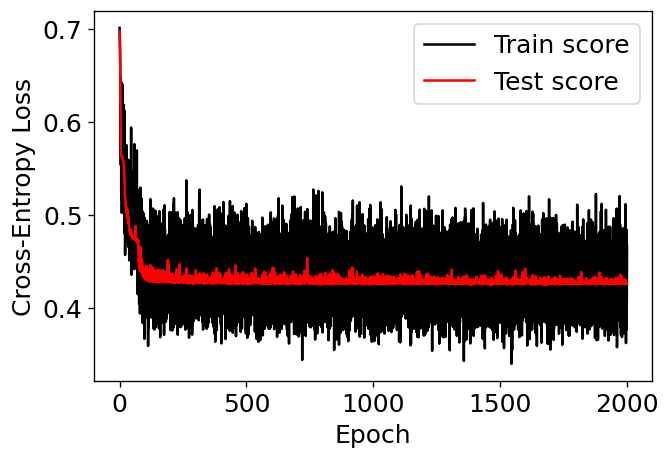

250 0.8842504743833017 0.631006450135491
500 0.8842504743833017 0.631006450135491
750 0.888045540796964 0.6360825922674707
1000 0.8785578747628083 0.6283729628640129
1250 0.8842504743833017 0.6359871760619824
1500 0.888045540796964 0.6410633181939621
1750 0.8861480075901328 0.6186023434220068
---------------------------------------------


100%|██████████| 2000/2000 [01:18<00:00, 25.38it/s]


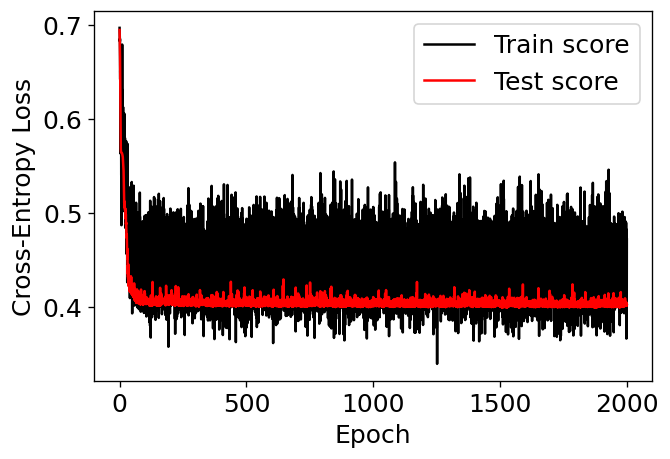

250 0.905123339658444 0.6788481355673447
500 0.9032258064516129 0.6862715163543376
750 0.9146110056925996 0.6865577649708027
1000 0.9032258064516129 0.6862715163543376
1250 0.9146110056925996 0.6915384908972939
1500 0.9127134724857685 0.6939811457577956
1750 0.9165085388994307 0.6940765619632838
---------------------------------------------


100%|██████████| 2000/2000 [01:18<00:00, 25.43it/s]


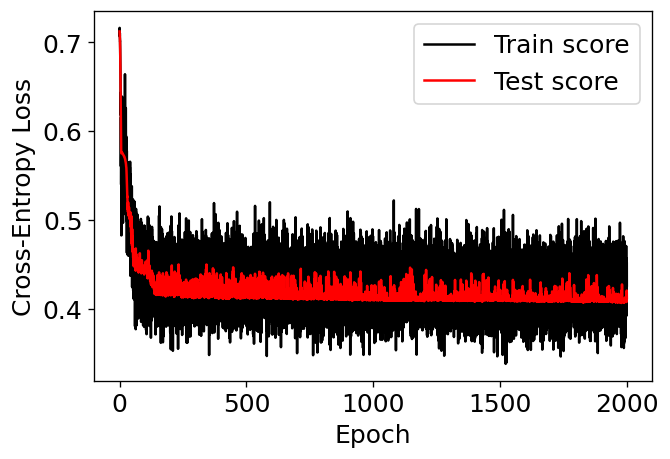

250 0.8994307400379506 0.6417896610546615
500 0.8785578747628083 0.64114069569087
750 0.9032258064516129 0.6607950752799823
1000 0.9032258064516129 0.6792627753467328
1250 0.9013282732447818 0.6720685307424163
1500 0.905123339658444 0.6726062449009864
1750 0.905123339658444 0.6772231699176741
---------------------------------------------


100%|██████████| 2000/2000 [01:20<00:00, 24.95it/s]


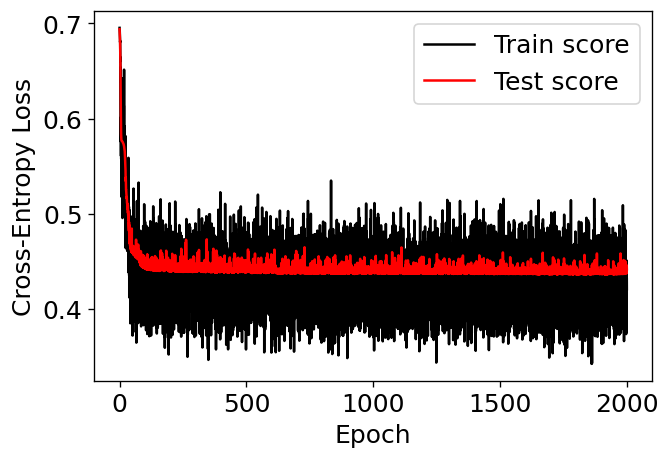

RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [01:20<00:00, 24.99it/s]


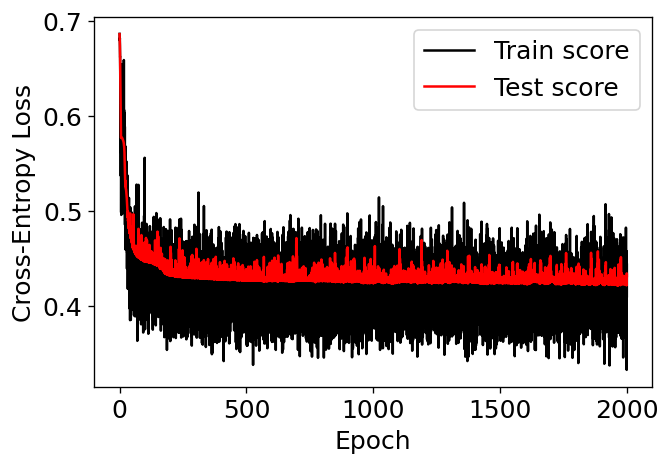

250 0.8538899430740038 0.5776485788113696
500 0.888045540796964 0.6241602067183463
750 0.8823529411764706 0.6072905131044666
1000 0.8918406072106262 0.6293281653746771
1250 0.8823529411764706 0.5890550018456995
1500 0.888045540796964 0.6104835732742709
1750 0.8861480075901328 0.6033407161314138
---------------------------------------------


100%|██████████| 2000/2000 [01:19<00:00, 25.10it/s]


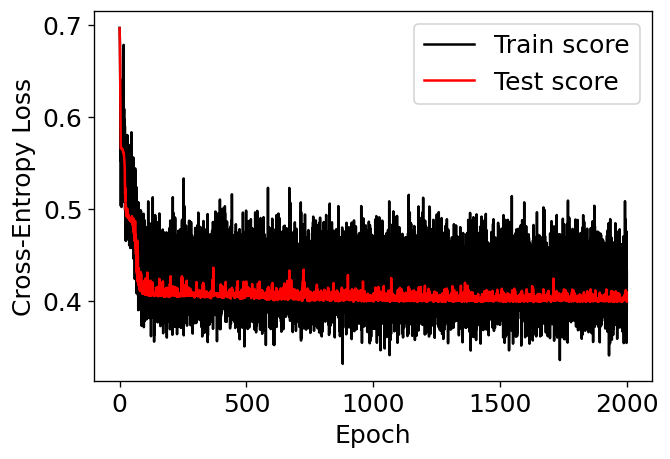

250 0.9032258064516129 0.6636664008203258
500 0.8994307400379506 0.6634954996012304
750 0.9108159392789373 0.6935171470889825
1000 0.9108159392789373 0.6689263605635942
1250 0.9070208728652751 0.6835099312597319
1500 0.9089184060721063 0.690972617826896
1750 0.9108159392789373 0.6787626751737496
---------------------------------------------
ARCH = VDFCNN_4040_CNN3_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 91.6+/-1.3564659966250534
TN = 377.0+/-9.444575162494075
FP = 14.2+/-8.084553172563094
FN = 44.2+/-3.762977544445356
Acc = 0.8891840607210627+/-0.019111466128294757
TSS = 0.6385918452778385+/-0.03473081691045391
=>=>=> NUMBER OF EPOCHS: 500
TP = 93.4+/-2.727636339397171
TN = 376.0+/-5.329165037789691
FP = 15.2+/-4.308131845707603
FN = 42.4+/-3.8781438859330635
Acc = 0.8907020872865274+/-0.009264937848754224
TSS = 0.6492148737000549+/-0.02281055202195433
=>=>=> NUMBER OF EPOCHS: 750
TP = 92.4+/-2.5768197453450252
TN = 381.8+/-4.578209256903839
FP = 9.4+/-3.9293765408777004
FN = 43.4+/-4.

In [11]:
# NETWORK: VDFCNN_4040_CNN3_CONN2
ARCH = 'VDFCNN_4040_CNN3_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:15<00:00, 26.33it/s]


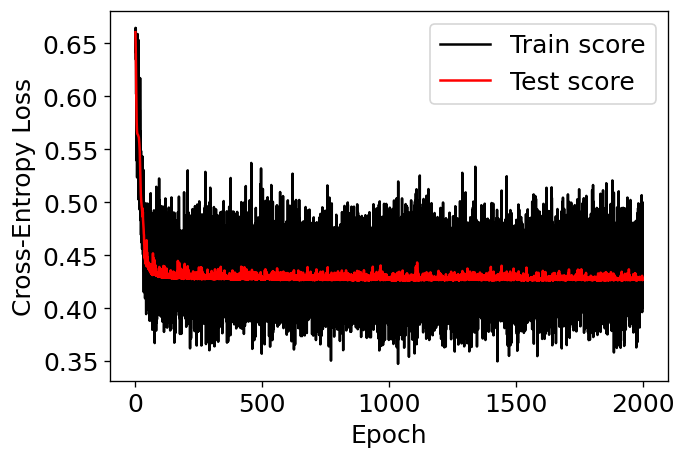

250 0.8709677419354839 0.6182206786000535
500 0.888045540796964 0.6311018663409793
750 0.8861480075901328 0.623583069348498
1000 0.8842504743833017 0.6359871760619824
1250 0.8861480075901328 0.623583069348498
1500 0.8823529411764706 0.6284683790695011
1750 0.8861480075901328 0.623583069348498
---------------------------------------------


100%|██████████| 2000/2000 [01:16<00:00, 26.27it/s]


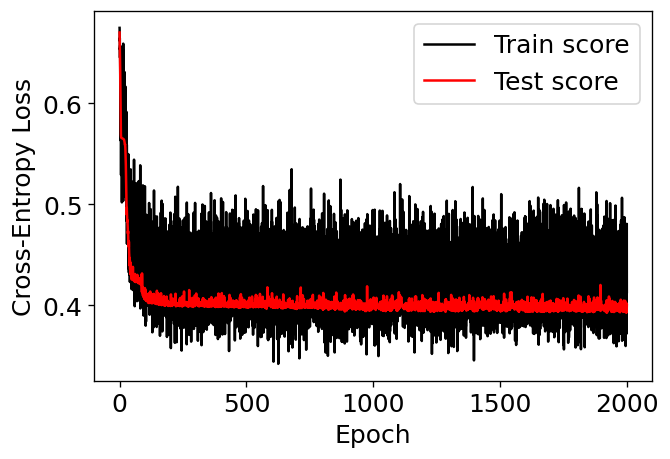

250 0.9089184060721063 0.6590206480668677
500 0.9108159392789373 0.6765008969123315
750 0.9108159392789373 0.696423800618297
1000 0.9108159392789373 0.696423800618297
1250 0.9146110056925996 0.6616541353383458
1500 0.9108159392789373 0.681481622838823
1750 0.9127134724857685 0.6840196939048128
---------------------------------------------


100%|██████████| 2000/2000 [01:16<00:00, 26.03it/s]


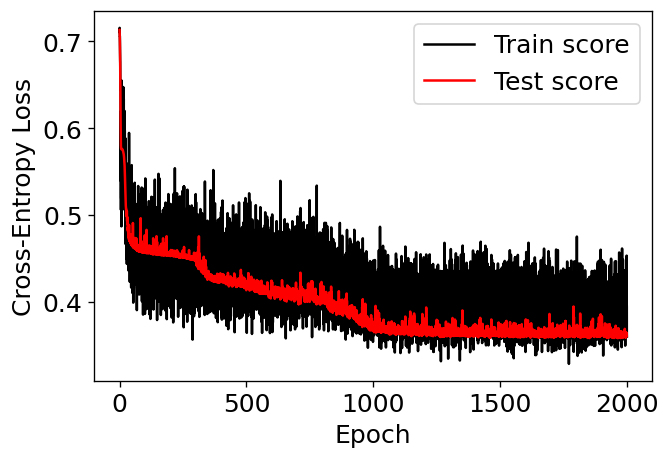

250 0.8614800759013282 0.5302232440851442
500 0.8956356736242884 0.6874211970629682
750 0.9032258064516129 0.6884966253801083
1000 0.9487666034155597 0.8426907958169546
1250 0.9430740037950665 0.8672773121708819
1500 0.9392789373814042 0.8621226729956241
1750 0.952561669829222 0.8524623600089001
---------------------------------------------


100%|██████████| 2000/2000 [01:16<00:00, 26.00it/s]


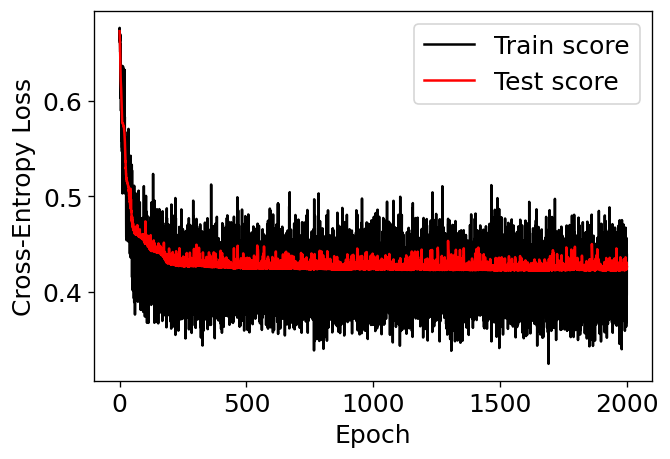

250 0.8956356736242884 0.6208194905869324
500 0.8785578747628083 0.5610926541159099
750 0.889943074003795 0.6130675526024363
1000 0.8861480075901328 0.6078995939461056
1250 0.888045540796964 0.6196013289036545
1500 0.8975332068311196 0.6325212255444814
1750 0.889943074003795 0.6085086747877446
---------------------------------------------


100%|██████████| 2000/2000 [01:17<00:00, 25.96it/s]


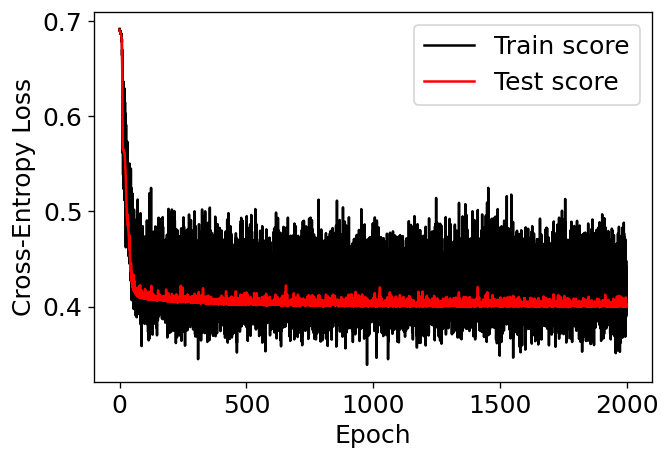

250 0.9013282732447818 0.6611218715582393
500 0.9013282732447818 0.6512855569480841
750 0.9032258064516129 0.6390756142949375
1000 0.9127134724857685 0.6763890471307584
1250 0.9070208728652751 0.6736736166495766
1500 0.9013282732447818 0.6316129277277733
1750 0.9146110056925996 0.6887698910030003
---------------------------------------------
ARCH = VDFCNN_4040_CNN3_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 87.6+/-5.0039984012787215
TN = 380.2+/-7.547184905645284
FP = 11.0+/-8.246211251235321
FN = 48.2+/-7.386474125047754
Acc = 0.8876660341555975+/-0.018255807925321752
TSS = 0.6178811865794474+/-0.04744444308139169
=>=>=> NUMBER OF EPOCHS: 500
TP = 90.6+/-7.031358332498779
TN = 381.0+/-6.2289646009589745
FP = 10.2+/-5.3814496188294845
FN = 45.2+/-7.833262411026456
Acc = 0.894876660341556+/-0.01103836020664059
TSS = 0.6414804342760546+/-0.04472814950514856
=>=>=> NUMBER OF EPOCHS: 750
TP = 91.8+/-5.230678732248808
TN = 381.8+/-4.445222154178573
FP = 9.4+/-3.9799497484264794
FN = 44.0+/-5.4

In [12]:
# NETWORK: VDFCNN_4040_CNN3_CONN1
ARCH = 'VDFCNN_4040_CNN3_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:12<00:00, 27.41it/s]


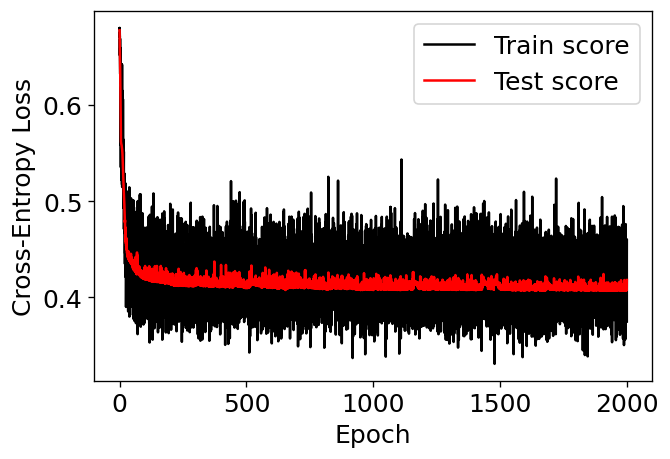

250 0.9032258064516129 0.6514064348688982
500 0.9013282732447818 0.6339261860234342
750 0.8994307400379506 0.6513110186634098
1000 0.9013282732447818 0.658829815655891
1250 0.8975332068311196 0.6537536735239113
1500 0.8975332068311196 0.6487729475974199
1750 0.9013282732447818 0.658829815655891
---------------------------------------------


100%|██████████| 2000/2000 [01:13<00:00, 27.22it/s]


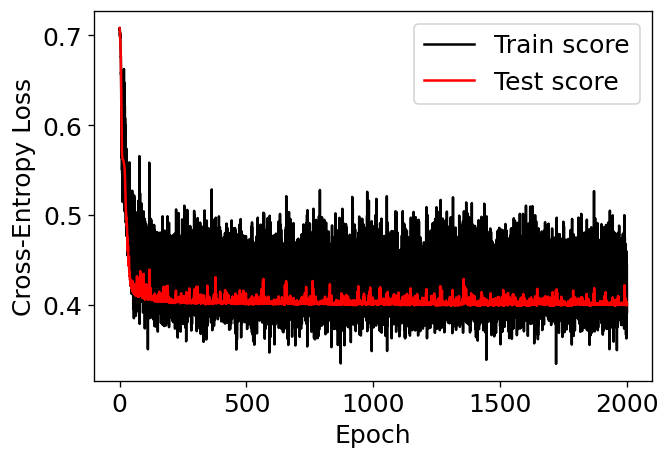

250 0.9013282732447818 0.6887141712148391
500 0.9146110056925996 0.6815770390443112
750 0.9108159392789373 0.681481622838823
1000 0.9108159392789373 0.6715201709858403
1250 0.9165085388994307 0.6940765619632838
1500 0.9108159392789373 0.6765008969123315
1750 0.9127134724857685 0.6840196939048128
---------------------------------------------


100%|██████████| 2000/2000 [01:13<00:00, 27.08it/s]


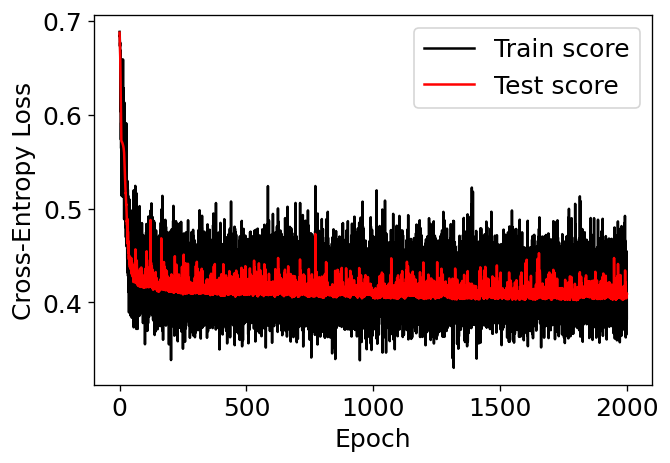

250 0.9070208728652751 0.6751835644886153
500 0.905123339658444 0.6864570199510495
750 0.9032258064516129 0.6654120002966698
1000 0.9089184060721063 0.6823778090929318
1250 0.9089184060721063 0.6916116591263072
1500 0.8785578747628083 0.6457576207075576
1750 0.9089184060721063 0.6869947341096194
---------------------------------------------


100%|██████████| 2000/2000 [01:14<00:00, 26.91it/s]


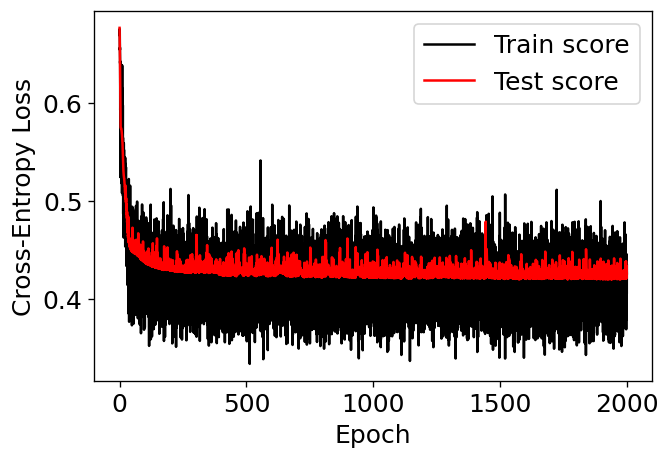

250 0.8842504743833017 0.6189922480620156
500 0.8918406072106262 0.6293281653746771
750 0.8937381404174574 0.6136766334440753
1000 0.8804554079696395 0.5636766334440753
1250 0.888045540796964 0.5968069398301956
1500 0.8918406072106262 0.6202104097452934
1750 0.8937381404174574 0.6182355112587671
---------------------------------------------


100%|██████████| 2000/2000 [01:13<00:00, 27.09it/s]


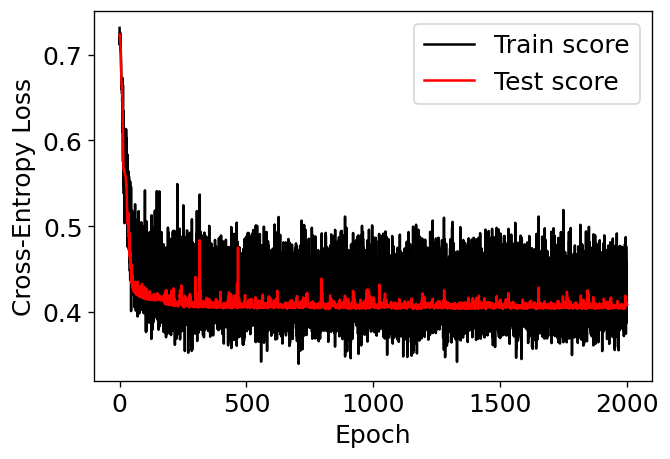

250 0.905123339658444 0.6662109300824124
500 0.9070208728652751 0.6736736166495766
750 0.9089184060721063 0.6712999886065854
1000 0.9070208728652751 0.6835099312597319
1250 0.9070208728652751 0.6638373020394212
1500 0.9032258064516129 0.6784208727355588
1750 0.9013282732447818 0.6414492423379287
---------------------------------------------
ARCH = VDFCNN_4040_CNN2_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 93.0+/-3.03315017762062
TN = 381.4+/-4.409081537009721
FP = 9.8+/-3.709447398198282
FN = 42.8+/-4.166533331199932
Acc = 0.9001897533206831+/-0.008192422445891032
TSS = 0.660101469743356+/-0.023870708040396794
=>=>=> NUMBER OF EPOCHS: 500
TP = 92.2+/-4.166533331199932
TN = 384.2+/-4.955804677345546
FP = 7.0+/-2.1908902300206643
FN = 43.6+/-3.6660605559646724
Acc = 0.9039848197343454+/-0.007456122468458613
TSS = 0.6609924054086098+/-0.024364692417439077
=>=>=> NUMBER OF EPOCHS: 750
TP = 91.4+/-2.727636339397171
TN = 384.6+/-2.244994432064365
FP = 6.6+/-2.244994432064365
FN = 44.4+/-4.4988

In [13]:
# NETWORK: VDFCNN_4040_CNN2_CONN2
ARCH = 'VDFCNN_4040_CNN2_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN2_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:09<00:00, 28.91it/s]


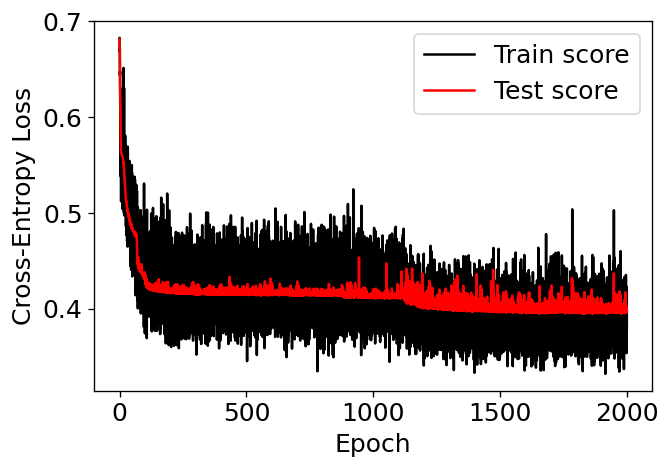

250 0.8975332068311196 0.6487729475974199
500 0.8994307400379506 0.6413495668104271
750 0.8994307400379506 0.6413495668104271
1000 0.9013282732447818 0.658829815655891
1250 0.8994307400379506 0.696137552001832
1500 0.9127134724857685 0.6790389679783214
1750 0.9184060721062619 0.7264989885882218
---------------------------------------------


100%|██████████| 2000/2000 [01:10<00:00, 28.51it/s]


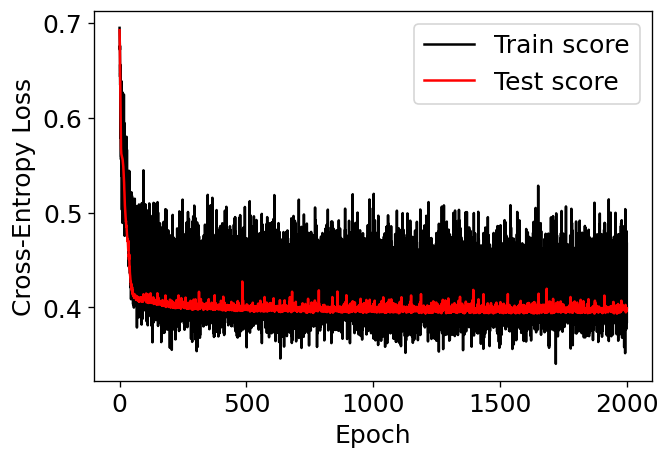

250 0.9089184060721063 0.6689820999198504
500 0.9108159392789373 0.681481622838823
750 0.9146110056925996 0.6865577649708027
1000 0.9127134724857685 0.6840196939048128
1250 0.9222011385199241 0.7016907751612533
1500 0.9146110056925996 0.6815770390443112
1750 0.9108159392789373 0.681481622838823
---------------------------------------------


100%|██████████| 2000/2000 [01:10<00:00, 28.43it/s]


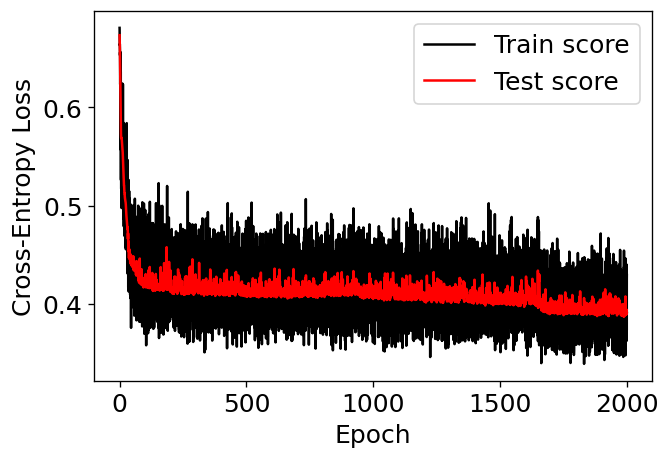

250 0.9032258064516129 0.6561781502632945
500 0.8975332068311196 0.662296966550471
750 0.9032258064516129 0.6515612252466069
1000 0.9070208728652751 0.707502039605429
1250 0.9108159392789373 0.6711043536304977
1500 0.9184060721062619 0.7183490321145145
1750 0.9278937381404174 0.7497033301194097
---------------------------------------------


100%|██████████| 2000/2000 [01:11<00:00, 27.95it/s]


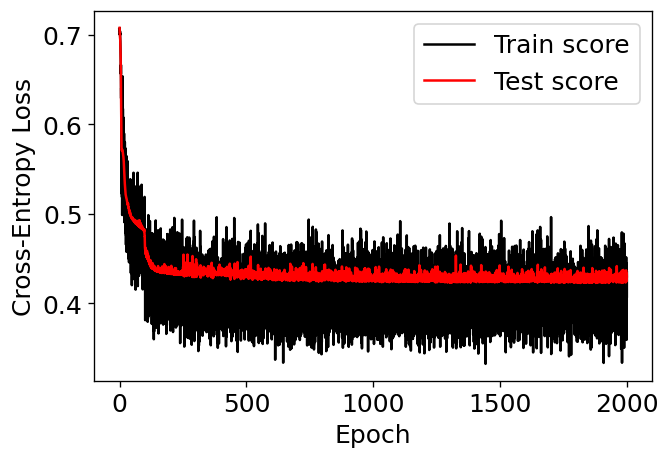

250 0.8918406072106262 0.6293281653746771
500 0.8861480075901328 0.6215762273901809
750 0.8937381404174574 0.6410299003322258
1000 0.8937381404174574 0.6319121447028424
1250 0.8956356736242884 0.6344961240310077
1500 0.8823529411764706 0.5753783684016243
1750 0.8975332068311196 0.6416389811738649
---------------------------------------------


100%|██████████| 2000/2000 [01:11<00:00, 27.93it/s]


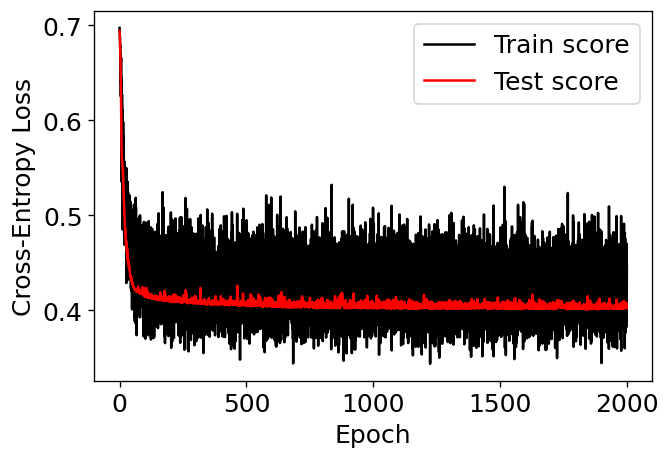

250 0.9013282732447818 0.6611218715582393
500 0.9089184060721063 0.6663818313015077
750 0.9089184060721063 0.6614636739964301
1000 0.9089184060721063 0.6614636739964301
1250 0.9146110056925996 0.6838517336979226
1500 0.9089184060721063 0.6712999886065854
1750 0.905123339658444 0.67112908738749
---------------------------------------------
ARCH = VDFCNN_4040_CNN2_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 91.4+/-1.019803902718557
TN = 383.2+/-2.85657137141714
FP = 8.0+/-2.280350850198276
FN = 44.4+/-2.727636339397171
Acc = 0.9005692599620494+/-0.005705235817219317
TSS = 0.6528766469426962+/-0.01348807325908161
=>=>=> NUMBER OF EPOCHS: 500
TP = 91.8+/-2.6381811916545836
TN = 382.8+/-5.192301994298868
FP = 8.4+/-2.33238075793812
FN = 44.0+/-2.9664793948382653
Acc = 0.9005692599620494+/-0.008867796163603737
TSS = 0.6546172429782819+/-0.020913242406857224
=>=>=> NUMBER OF EPOCHS: 750
TP = 91.2+/-1.9390719429665317
TN = 385.2+/-4.069397989875161
FP = 6.0+/-2.0976176963403033
FN = 44.6+/-2.57681

In [14]:
# NETWORK: VDFCNN_4040_CNN2_CONN1
ARCH = 'VDFCNN_4040_CNN2_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN2_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:03<00:00, 31.35it/s]


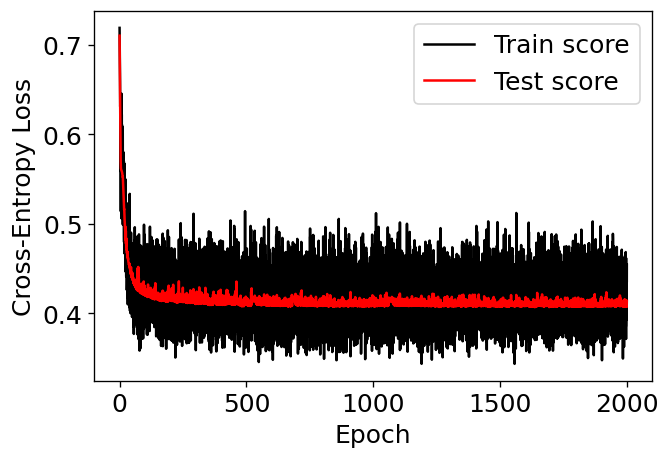

250 0.8994307400379506 0.626407389030953
500 0.8994307400379506 0.6463302927369184
750 0.8994307400379506 0.6562917445899011
1000 0.9013282732447818 0.658829815655891
1250 0.9070208728652751 0.6564825770008779
1500 0.9070208728652751 0.6564825770008779
1750 0.9070208728652751 0.6664440288538606
---------------------------------------------


100%|██████████| 2000/2000 [01:04<00:00, 30.92it/s]


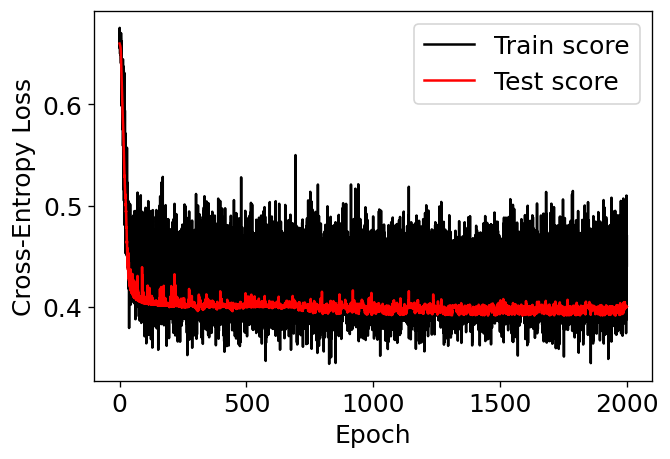

250 0.9146110056925996 0.6915384908972939
500 0.9146110056925996 0.7014999427502767
750 0.9146110056925996 0.6815770390443112
1000 0.9127134724857685 0.6790389679783214
1250 0.9127134724857685 0.6890004198313041
1500 0.9165085388994307 0.6691729323308271
1750 0.9222011385199241 0.6917293233082706
---------------------------------------------


100%|██████████| 2000/2000 [01:04<00:00, 31.12it/s]


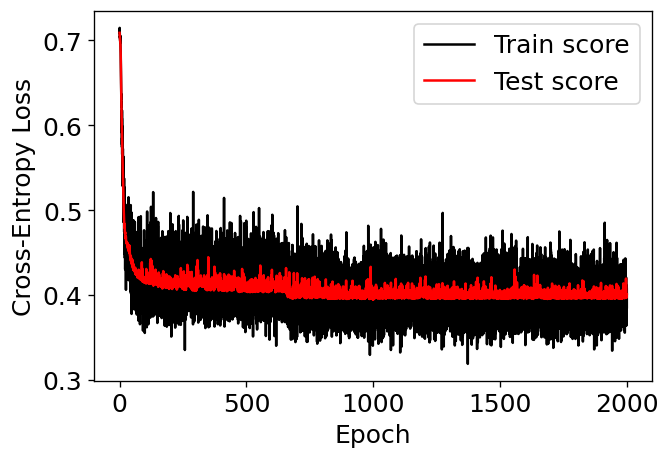

250 0.9070208728652751 0.66594971445524
500 0.9184060721062619 0.7044982570644516
750 0.9146110056925996 0.6947266928725061
1000 0.920303605313093 0.725543276718831
1250 0.8975332068311196 0.6853815916339094
1500 0.9184060721062619 0.7091151820811392
1750 0.9165085388994307 0.7157717125268857
---------------------------------------------


100%|██████████| 2000/2000 [01:04<00:00, 30.85it/s]


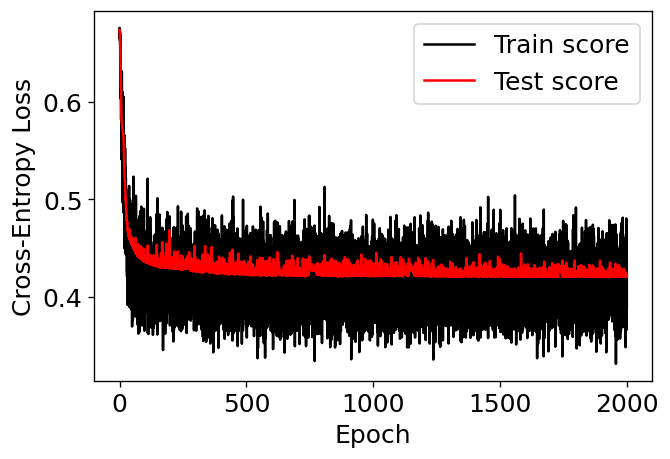

250 0.8823529411764706 0.5890550018456995
500 0.8937381404174574 0.6319121447028424
750 0.8842504743833017 0.5961978589885567
1000 0.8861480075901328 0.6215762273901809
1250 0.8937381404174574 0.6182355112587671
1500 0.889943074003795 0.6176264304171281
1750 0.8975332068311196 0.6370801033591732
---------------------------------------------


100%|██████████| 2000/2000 [01:04<00:00, 31.05it/s]


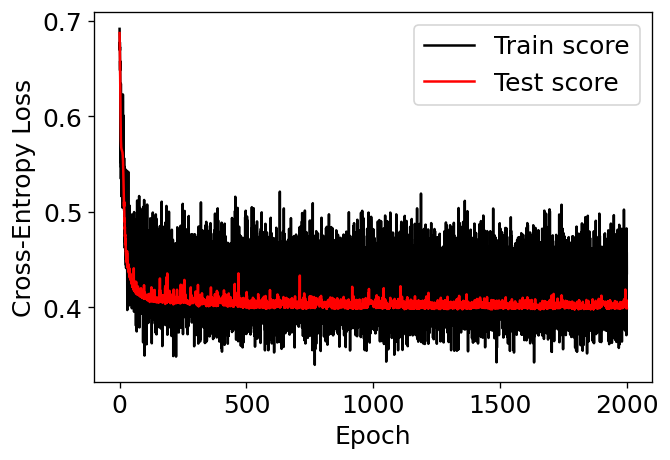

250 0.9070208728652751 0.6736736166495766
500 0.9108159392789373 0.688598989783905
750 0.9032258064516129 0.6390756142949375
1000 0.9089184060721063 0.6811363032167408
1250 0.9070208728652751 0.6736736166495766
1500 0.9108159392789373 0.6836808324788273
1750 0.9089184060721063 0.6762181459116631
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 90.2+/-4.261455150532504
TN = 385.2+/-3.1874754901018454
FP = 6.0+/-1.4142135623730951
FN = 45.6+/-5.642694391866353
Acc = 0.9020872865275141+/-0.010972927737989335
TSS = 0.6493248425757526+/-0.03690231604418963
=>=>=> NUMBER OF EPOCHS: 500
TP = 94.0+/-3.5777087639996634
TN = 384.2+/-2.1354156504062622
FP = 7.0+/-2.0976176963403033
FN = 41.8+/-4.261455150532504
Acc = 0.9074003795066414+/-0.009326911368079309
TSS = 0.6745679254076788+/-0.029782238348197064
=>=>=> NUMBER OF EPOCHS: 750
TP = 90.8+/-4.261455150532504
TN = 385.2+/-3.7629775444453557
FP = 6.0+/-2.756809750418044
FN = 45.0+/-5

In [15]:
# NETWORK: VDFCNN_4040_CNN1_CONN2
ARCH = 'VDFCNN_4040_CNN1_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:05<00:00, 30.43it/s]


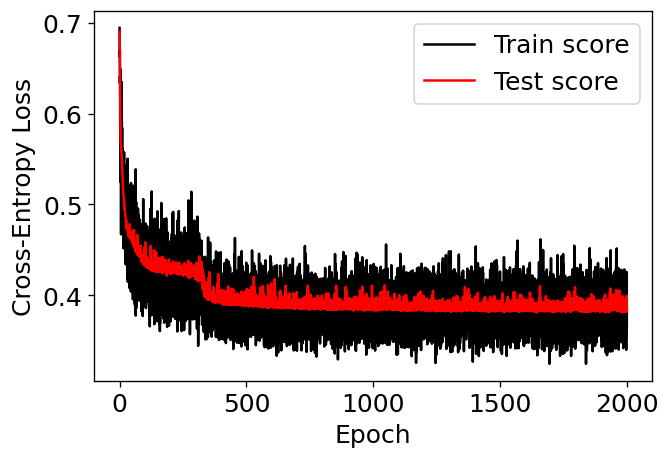

250 0.8937381404174574 0.6735811610243884
500 0.9222011385199241 0.7514980344261669
750 0.9278937381404174 0.7640929735506279
1000 0.9354838709677419 0.7692645318880958
1250 0.9278937381404174 0.7790351513301018
1500 0.9165085388994307 0.7488645471546888
1750 0.9316888045540797 0.7542269379031334
---------------------------------------------


100%|██████████| 2000/2000 [01:02<00:00, 31.94it/s]


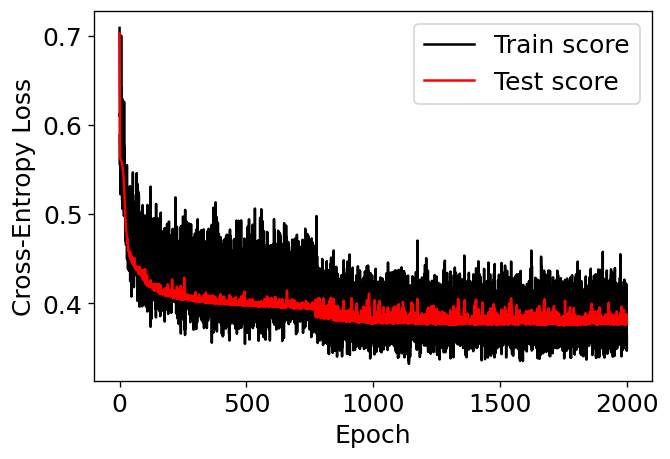

250 0.9032258064516129 0.6464257089424067
500 0.9184060721062619 0.7115568108087478
750 0.9184060721062619 0.7165375367352391
1000 0.937381404174573 0.7867447807335598
1250 0.9411764705882353 0.7669172932330827
1500 0.9411764705882353 0.7968016487920307
1750 0.9354838709677419 0.7792259837410785
---------------------------------------------


100%|██████████| 2000/2000 [01:04<00:00, 30.85it/s]


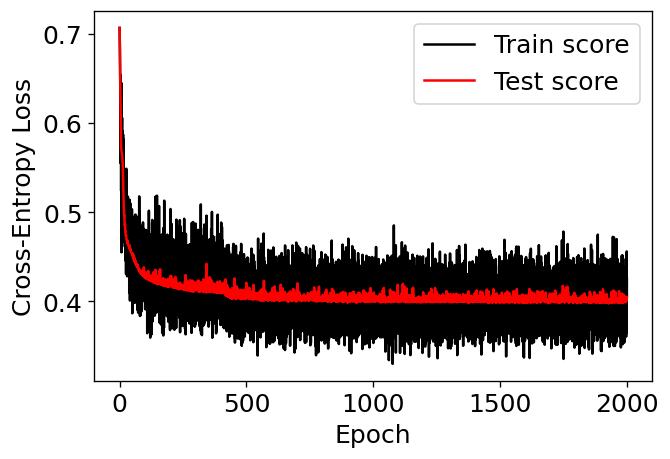

250 0.905123339658444 0.6679893198842988
500 0.9184060721062619 0.7091151820811392
750 0.920303605313093 0.7163094266854558
1000 0.920303605313093 0.7209263517021435
1250 0.9184060721062619 0.7183490321145145
1500 0.9165085388994307 0.7065378624935104
1750 0.9165085388994307 0.7019209374768227
---------------------------------------------


100%|██████████| 2000/2000 [01:04<00:00, 30.83it/s]


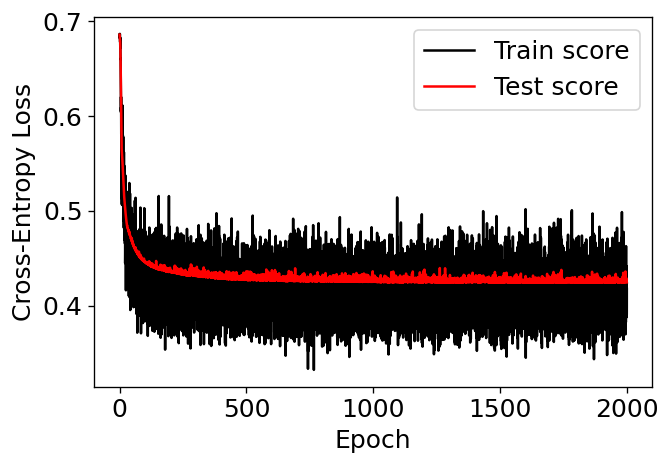

250 0.8861480075901328 0.6170173495754891
500 0.8823529411764706 0.6164082687338501
750 0.889943074003795 0.62218530823182
1000 0.888045540796964 0.6150424510889627
1250 0.8918406072106262 0.6202104097452934
1500 0.8918406072106262 0.6293281653746771
1750 0.8956356736242884 0.6253783684016242
---------------------------------------------


100%|██████████| 2000/2000 [01:06<00:00, 30.02it/s]


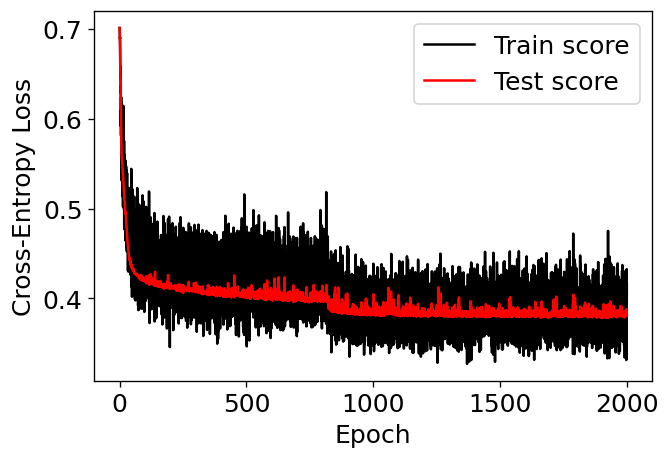

250 0.905123339658444 0.6662109300824124
500 0.9165085388994307 0.7159052067904751
750 0.9184060721062619 0.7184497360525617
1000 0.9259962049335864 0.7335460104059854
1250 0.9240986717267552 0.7260833238388212
1500 0.9392789373814042 0.7907029736812122
1750 0.9335863377609108 0.7732330712847973
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 92.2+/-2.993325909419153
TN = 381.4+/-4.841487374764082
FP = 9.8+/-4.833218389437829
FN = 43.6+/-4.223742416388575
Acc = 0.8986717267552182+/-0.007552086809158416
TSS = 0.6542448939017991+/-0.020750981681341464
=>=>=> NUMBER OF EPOCHS: 500
TP = 98.2+/-4.261455150532504
TN = 382.2+/-4.4
FP = 9.0+/-3.286335345030997
FN = 37.6+/-6.560487786742691
Acc = 0.91157495256167+/-0.014727596138089022
TSS = 0.7008967005680758+/-0.04495603796994624
=>=>=> NUMBER OF EPOCHS: 750
TP = 98.6+/-4.923413450036469
TN = 383.6+/-2.4166091947189146
FP = 7.6+/-1.9595917942265424
FN = 37.2+/-7.19444229944198
Acc 

In [16]:
# NETWORK: VDFCNN_4040_CNN1_CONN1
ARCH = 'VDFCNN_4040_CNN1_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

## Best Network Architecture

CONCLUSION:

Best network configuration: VDFCNN_4040_CNN1_CONN1 with 1750 epochs

Running for the best configuration now...

100%|██████████| 1750/1750 [01:00<00:00, 28.71it/s]


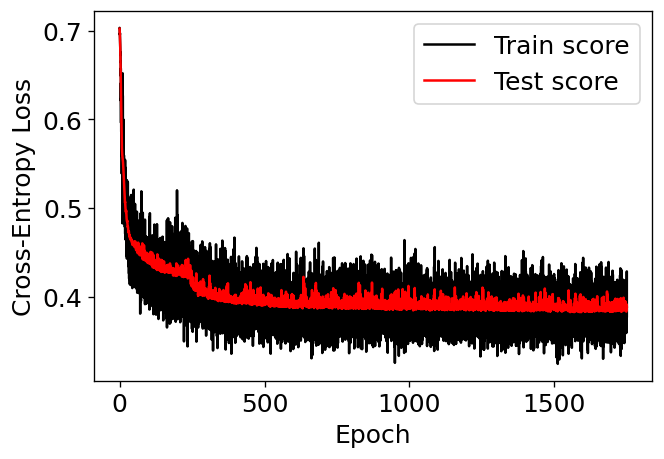

0.9278937381404174 -1
0.9278937381404174 0.7541315216976452
---------------------------------------------


100%|██████████| 1750/1750 [00:54<00:00, 32.01it/s]


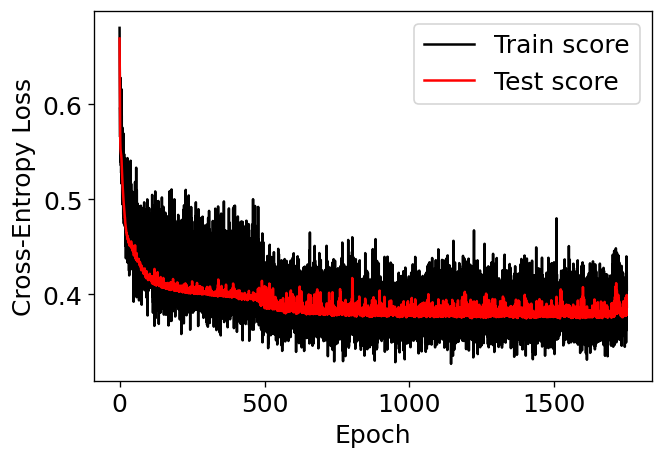

0.9259962049335864 -1
0.9259962049335864 0.776497080264112
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.17it/s]


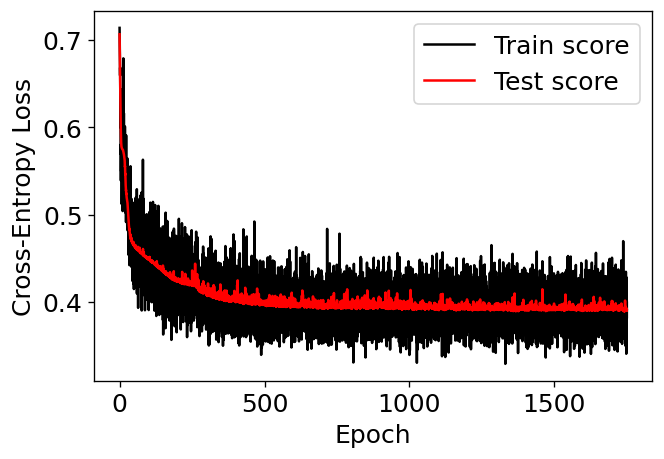

0.9259962049335864 -1
0.9259962049335864 0.7332752354817177
---------------------------------------------


100%|██████████| 1750/1750 [00:59<00:00, 29.46it/s]


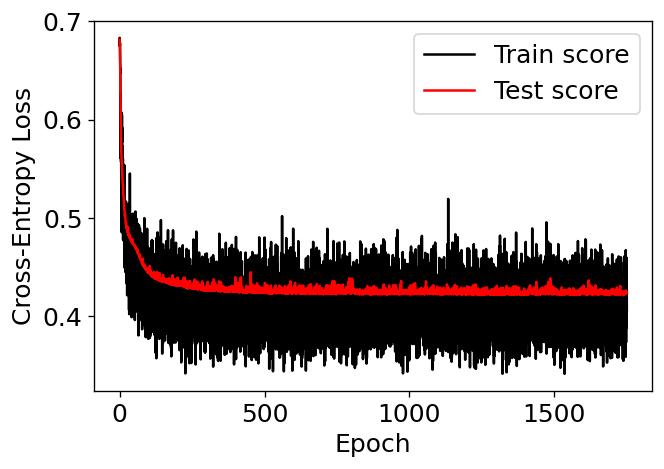

0.8918406072106262 -1
0.8918406072106262 0.6202104097452934
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.70it/s]


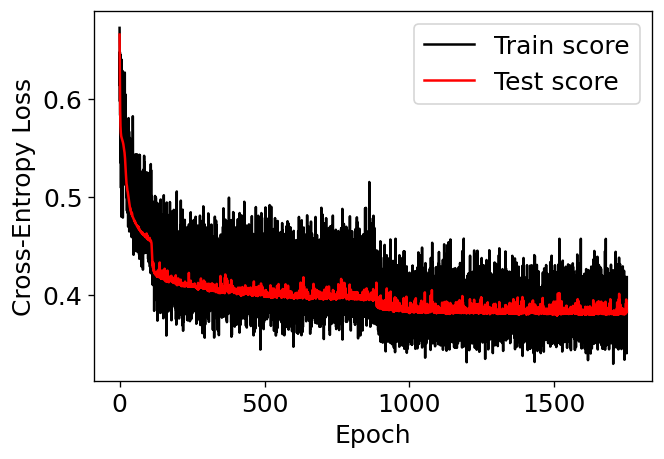

0.9278937381404174 -1
0.9278937381404174 0.7705176408036155
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.63it/s]


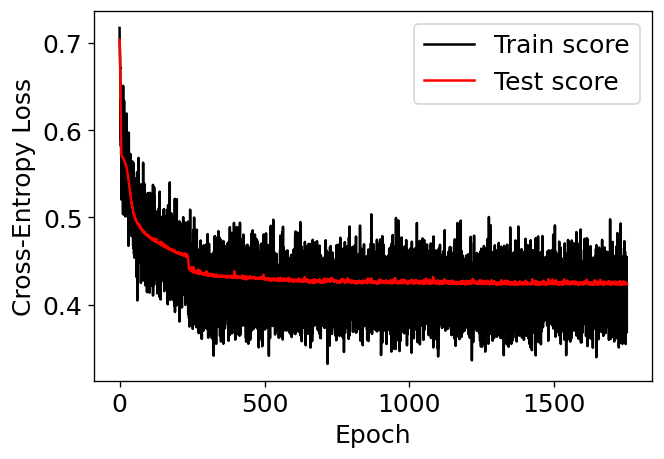

0.889943074003795 -1
0.889943074003795 0.5919676629830156
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.54it/s]


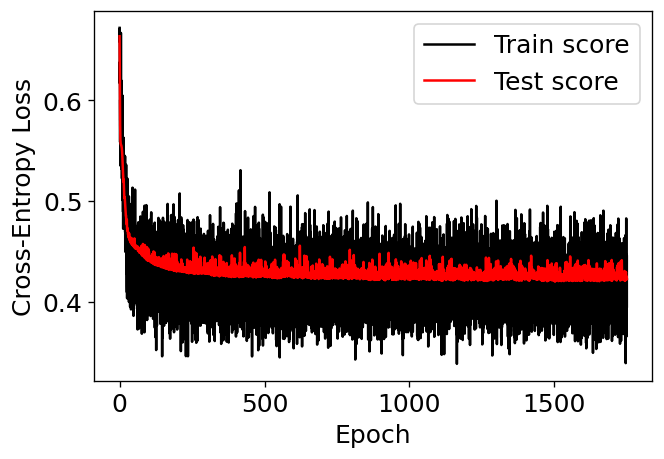

0.8994307400379506 -1
0.8994307400379506 0.6026545243169927
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.36it/s]


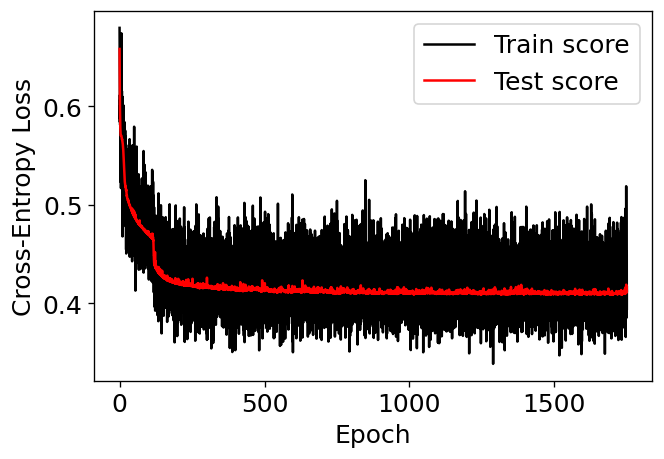

0.9032258064516129 -1
0.9032258064516129 0.6654120002966698
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.20it/s]


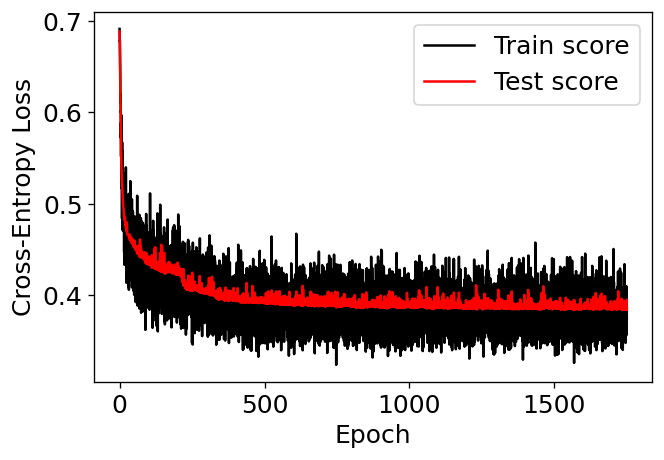

0.9354838709677419 -1
0.9354838709677419 0.7469128588679833
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 30.83it/s]


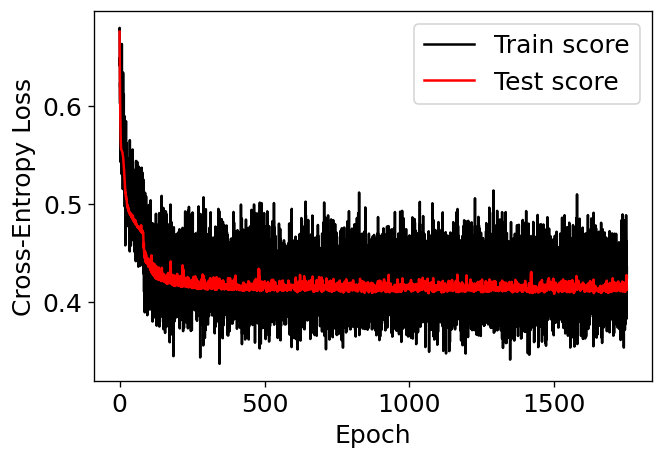

0.9089184060721063 -1
0.9089184060721063 0.6274212598425197
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN1
TP = 94.4+/-10.49952379872535
TN = 387.1+/-6.640030120413611
FP = 5.6+/-4.17612260356422
FN = 39.9+/-10.662551289442879
Acc = 0.9136622390891841+/-0.015994527903519178
TSS = 0.6889000194299565+/-0.07057494879088673


In [17]:
# NETWORK: VDFCNN_4040_CNN1_CONN1
ARCH = 'VDFCNN_4040_CNN1_CONN1'

tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 1750
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = -1

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

# Best architecture for 60x60 VDFs (5-fold CV for faster assessment)

In [18]:
class VDFCNN_6060_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*7*7+2, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 7 * 7)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN3_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN3_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*7*7+2, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 7 * 7)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN2_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN2_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*15*15+2, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 15 * 15)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN2_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN2_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*15*15+2, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 15 * 15)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN1_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN1_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*30*30+2, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 30 * 30)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN1_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN1_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*30*30+2, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-2]
    x_p = x[:, -2:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 30 * 30)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x

100%|██████████| 2000/2000 [02:18<00:00, 14.41it/s]


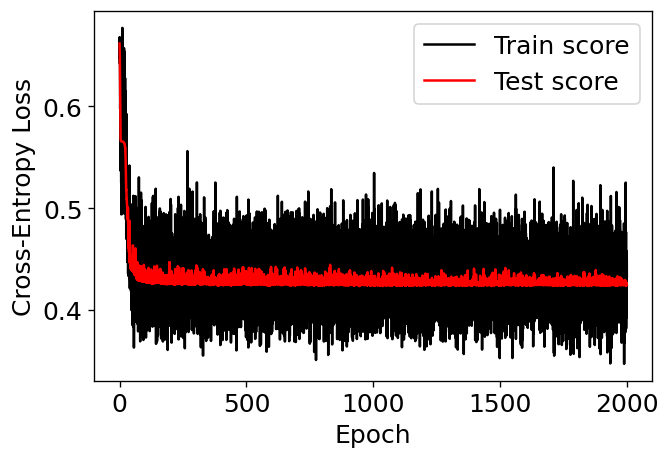

250 0.8690702087286527 0.6107018816075722
500 0.8709677419354839 0.6182206786000535
750 0.8861480075901328 0.6335445212014809
1000 0.889943074003795 0.6336399374069692
1250 0.8842504743833017 0.631006450135491
1500 0.8804554079696395 0.6309110339300027
1750 0.888045540796964 0.626121140414488
---------------------------------------------


100%|██████████| 2000/2000 [02:18<00:00, 14.43it/s]


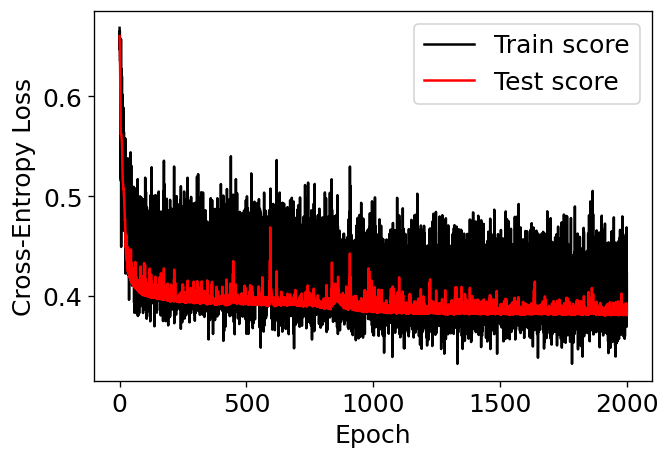

250 0.905123339658444 0.6788481355673447
500 0.920303605313093 0.7589214152131598
750 0.9222011385199241 0.7614594862791496
1000 0.9316888045540797 0.7791305675355903
1250 0.9259962049335864 0.7466127247051639
1500 0.9297912713472486 0.7666310446166177
1750 0.9297912713472486 0.7516888668371435
---------------------------------------------


100%|██████████| 2000/2000 [02:15<00:00, 14.79it/s]


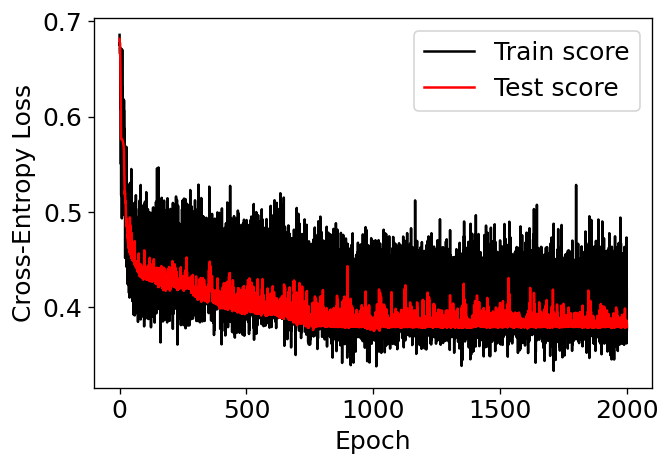

250 0.8937381404174574 0.6663761774085886
500 0.9089184060721063 0.7054624341763702
750 0.9316888045540797 0.7825595193947934
1000 0.9297912713472486 0.78921604984054
1250 0.9354838709677419 0.7877141585700511
1500 0.905123339658444 0.7557108952013647
1750 0.9108159392789373 0.7634428539642513
---------------------------------------------


100%|██████████| 2000/2000 [02:12<00:00, 15.11it/s]


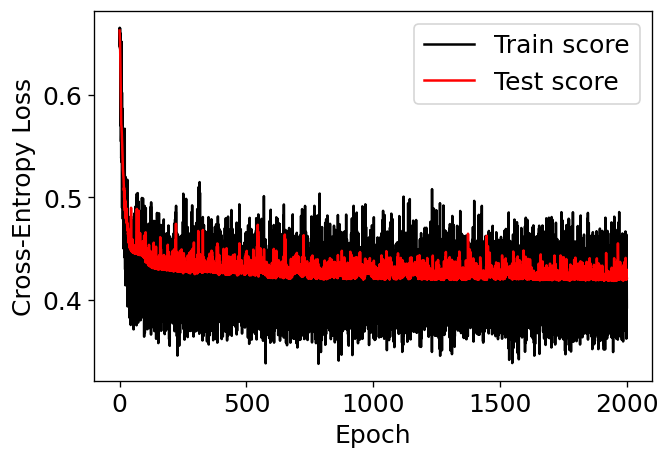

250 0.8861480075901328 0.6215762273901809
500 0.8709677419354839 0.6009043927648579
750 0.8861480075901328 0.6124584717607973
1000 0.889943074003795 0.6267441860465116
1250 0.889943074003795 0.6267441860465116
1500 0.8861480075901328 0.6215762273901809
1750 0.8975332068311196 0.6325212255444814
---------------------------------------------


100%|██████████| 2000/2000 [02:16<00:00, 14.60it/s]


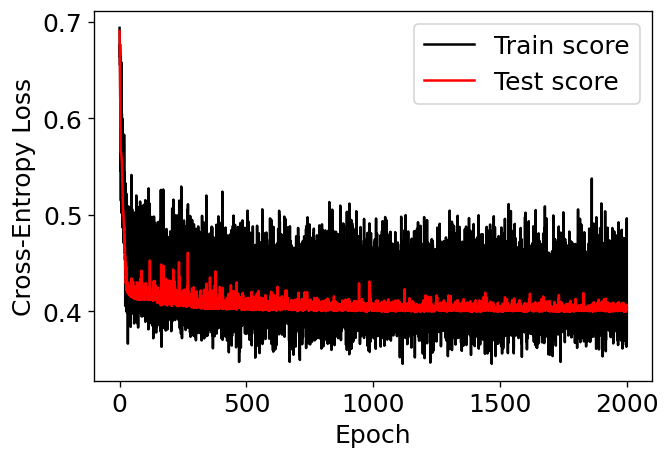

250 0.8975332068311196 0.6068512399832896
500 0.905123339658444 0.6809654019976454
750 0.9013282732447818 0.666040028863317
1000 0.9089184060721063 0.6663818313015077
1250 0.9070208728652751 0.6540009874292659
1500 0.9146110056925996 0.693688048308078
1750 0.9089184060721063 0.6762181459116631
---------------------------------------------
ARCH = VDFCNN_6060_CNN3_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 91.0+/-5.291502622129181
TN = 378.2+/-8.034923770640265
FP = 13.0+/-7.771743691090179
FN = 44.8+/-4.915282290977803
Acc = 0.8903225806451613+/-0.012262234854955261
TSS = 0.6368707323913951+/-0.02984149534482917
=>=>=> NUMBER OF EPOCHS: 500
TP = 97.0+/-6.0332412515993425
TN = 374.8+/-5.775811631277461
FP = 16.4+/-5.642694391866354
FN = 38.8+/-7.166589146867567
Acc = 0.8952561669829222+/-0.02045114775758251
TSS = 0.6728948645504174+/-0.057789691506704204
=>=>=> NUMBER OF EPOCHS: 750
TP = 98.0+/-9.273618495495704
TN = 379.2+/-1.7204650534085253
FP = 12.0+/-3.0983866769659336
FN = 37.8+/-9.43

In [19]:
# NETWORK: VDFCNN_6060_CNN3_CONN2
ARCH = 'VDFCNN_6060_CNN3_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [02:19<00:00, 14.38it/s]


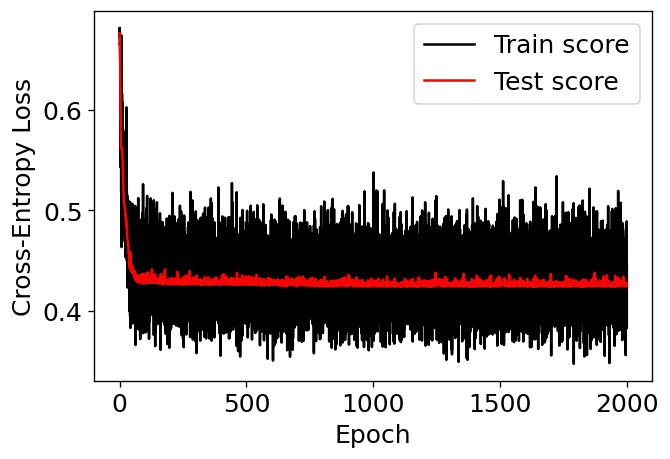

250 0.8861480075901328 0.6186023434220068
500 0.8804554079696395 0.6309110339300027
750 0.888045540796964 0.6360825922674707
1000 0.888045540796964 0.626121140414488
1250 0.8785578747628083 0.6233922369375214
1500 0.8842504743833017 0.631006450135491
1750 0.8918406072106262 0.6411587343994504
---------------------------------------------


100%|██████████| 2000/2000 [02:19<00:00, 14.29it/s]


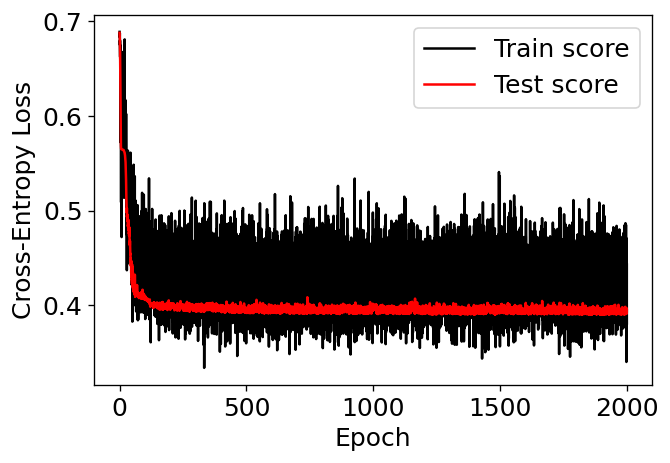

250 0.9127134724857685 0.6840196939048128
500 0.9127134724857685 0.6840196939048128
750 0.9278937381404174 0.7142857142857143
1000 0.9127134724857685 0.6790389679783214
1250 0.9165085388994307 0.6691729323308271
1500 0.9146110056925996 0.6965192168237854
1750 0.9165085388994307 0.6890958360367925
---------------------------------------------


100%|██████████| 2000/2000 [02:20<00:00, 14.22it/s]


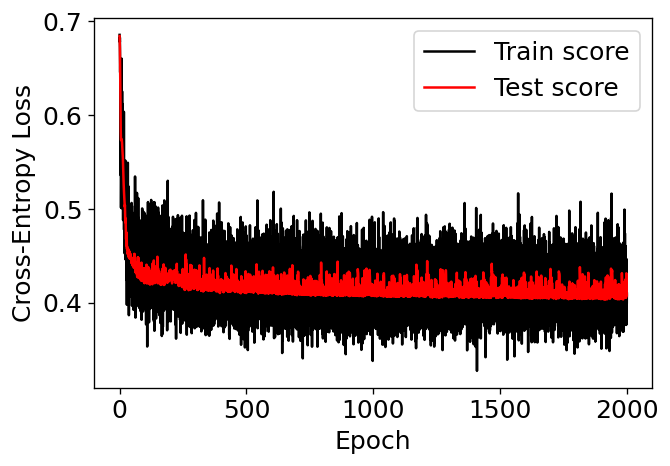

250 0.8994307400379506 0.646406586071349
500 0.9070208728652751 0.6844174145219906
750 0.9108159392789373 0.694188978713936
1000 0.9070208728652751 0.6798004895053029
1250 0.9108159392789373 0.694188978713936
1500 0.9108159392789373 0.694188978713936
1750 0.905123339658444 0.6679893198842988
---------------------------------------------


100%|██████████| 2000/2000 [02:19<00:00, 14.32it/s]


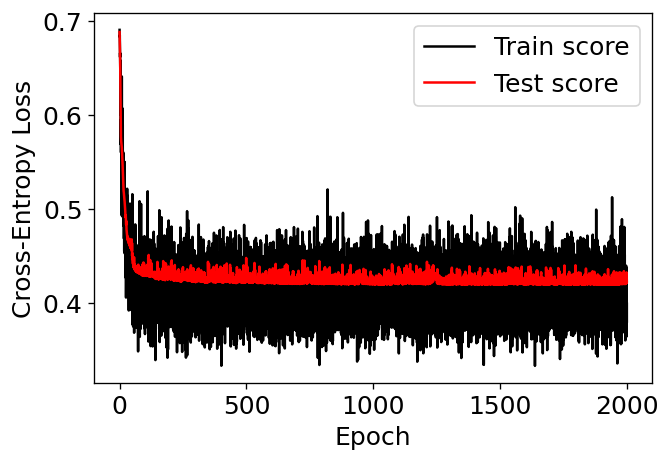

250 0.8785578747628083 0.6021225544481358
500 0.888045540796964 0.5968069398301956
750 0.8918406072106262 0.6247692875599853
1000 0.8994307400379506 0.6396640826873385
1250 0.8861480075901328 0.6215762273901809
1500 0.8842504743833017 0.6189922480620156
1750 0.8994307400379506 0.6396640826873385
---------------------------------------------


100%|██████████| 2000/2000 [02:09<00:00, 15.41it/s]


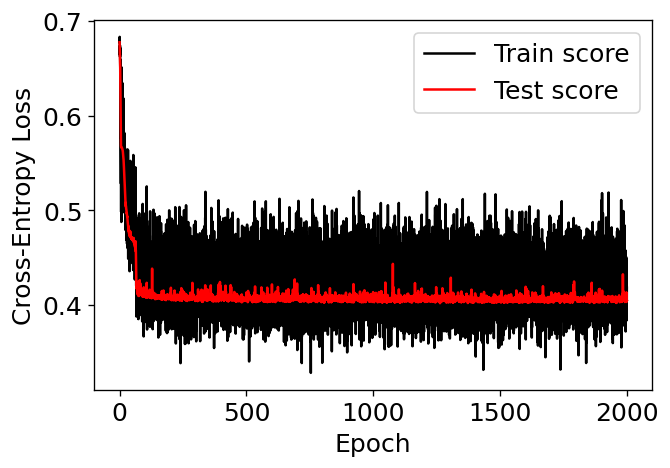

250 0.9032258064516129 0.6538300862101706
500 0.905123339658444 0.6662109300824124
750 0.9089184060721063 0.6762181459116631
1000 0.905123339658444 0.67112908738749
1250 0.905123339658444 0.6563746154722571
1500 0.9127134724857685 0.6911435190459915
1750 0.9089184060721063 0.6712999886065854
---------------------------------------------
ARCH = VDFCNN_6060_CNN3_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 90.2+/-2.1354156504062622
TN = 382.0+/-4.898979485566356
FP = 9.2+/-3.54400902933387
FN = 45.6+/-3.6110940170535577
Acc = 0.8960151802656545+/-0.012203366368738928
TSS = 0.640996252811295+/-0.02848735534017811
=>=>=> NUMBER OF EPOCHS: 500
TP = 91.8+/-4.166533331199932
TN = 381.8+/-5.1146847410177685
FP = 9.4+/-5.986651818838307
FN = 44.0+/-5.549774770204643
Acc = 0.8986717267552182+/-0.012273974670813063
TSS = 0.6524732024538829+/-0.03396468422892526
=>=>=> NUMBER OF EPOCHS: 750
TP = 93.4+/-3.3823069050575527
TN = 383.8+/-5.741080037762929
FP = 7.4+/-5.083306010855534
FN = 42.4+/-4.12795348

In [20]:
# NETWORK: VDFCNN_6060_CNN3_CONN1
ARCH = 'VDFCNN_6060_CNN3_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [02:00<00:00, 16.64it/s]


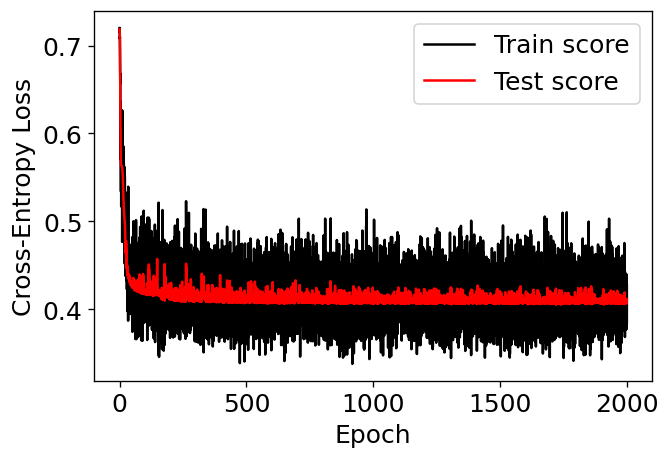

250 0.8994307400379506 0.6463302927369184
500 0.9032258064516129 0.6563871607953895
750 0.9070208728652751 0.6564825770008779
1000 0.905123339658444 0.6589252318613793
1250 0.8918406072106262 0.6461394603259418
1500 0.9089184060721063 0.6689820999198504
1750 0.8994307400379506 0.6513110186634098
---------------------------------------------


100%|██████████| 2000/2000 [02:03<00:00, 16.14it/s]


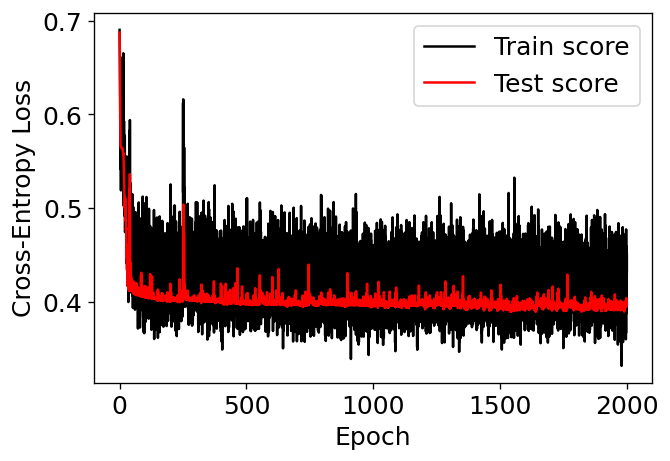

250 0.8500948766603416 0.5853211709476738
500 0.9108159392789373 0.6765008969123315
750 0.9165085388994307 0.6990572878897752
1000 0.9184060721062619 0.7065760848822563
1250 0.9165085388994307 0.709018739742758
1500 0.9146110056925996 0.7014999427502767
1750 0.9165085388994307 0.709018739742758
---------------------------------------------


100%|██████████| 2000/2000 [02:04<00:00, 16.04it/s]


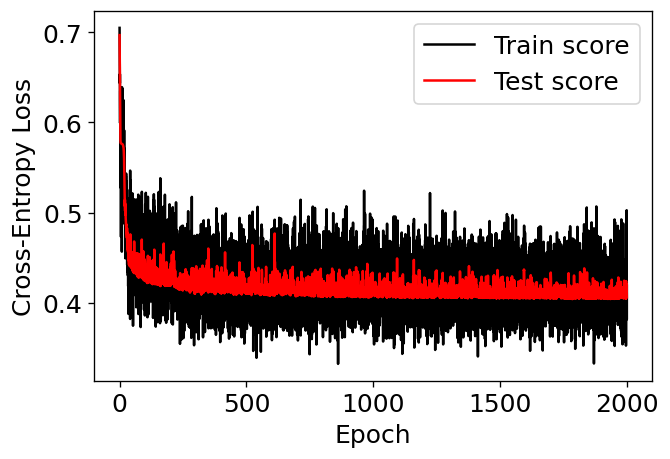

250 0.8937381404174574 0.6202069272417118
500 0.9013282732447818 0.6582177556923533
750 0.9032258064516129 0.6515612252466069
1000 0.9032258064516129 0.6561781502632945
1250 0.8804554079696395 0.6483349402951865
1500 0.905123339658444 0.6633723948676111
1750 0.8975332068311196 0.676147741600534
---------------------------------------------


100%|██████████| 2000/2000 [02:06<00:00, 15.78it/s]


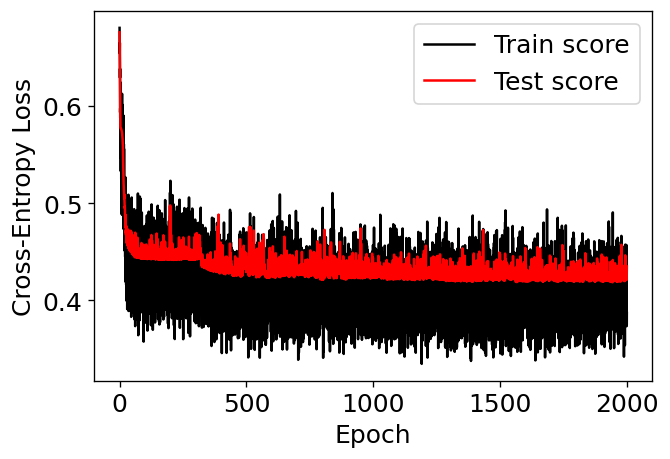

250 0.8652751423149905 0.5612403100775194
500 0.888045540796964 0.6332779623477298
750 0.8861480075901328 0.6215762273901809
1000 0.8804554079696395 0.5682355112587671
1250 0.8956356736242884 0.6299372462163161
1500 0.8785578747628083 0.6249169435215947
1750 0.8842504743833017 0.5870801033591732
---------------------------------------------


100%|██████████| 2000/2000 [02:02<00:00, 16.32it/s]


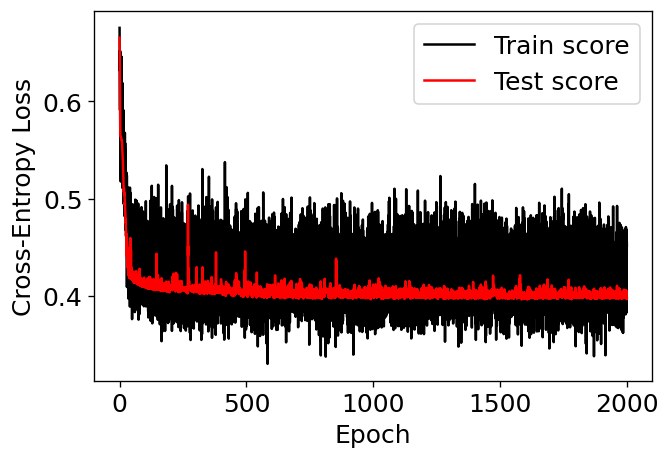

250 0.905123339658444 0.6662109300824124
500 0.9089184060721063 0.6614636739964301
750 0.905123339658444 0.6760472446925677
1000 0.9070208728652751 0.6490828301241882
1250 0.9108159392789373 0.6787626751737496
1500 0.9146110056925996 0.6838517336979226
1750 0.9184060721062619 0.7086134214424062
---------------------------------------------
ARCH = VDFCNN_6060_CNN2_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 88.6+/-2.65329983228432
TN = 376.6+/-10.480458005259122
FP = 14.6+/-11.182128598795488
FN = 47.2+/-5.418486873657627
Acc = 0.8827324478178369+/-0.02131327678496999
TSS = 0.6158619262172472+/-0.03846682015619641
=>=>=> NUMBER OF EPOCHS: 500
TP = 91.8+/-1.5999999999999999
TN = 383.8+/-5.192301994298868
FP = 7.4+/-2.65329983228432
FN = 44.0+/-2.0
Acc = 0.9024667931688806+/-0.008014691492198422
TSS = 0.6571694899488467+/-0.013889991381643672
=>=>=> NUMBER OF EPOCHS: 750
TP = 92.2+/-2.1354156504062622
TN = 384.0+/-4.604345773288535
FP = 7.2+/-2.7856776554368237
FN = 43.6+/-4.127953488110059
A

In [21]:
# NETWORK: VDFCNN_6060_CNN2_CONN2
ARCH = 'VDFCNN_6060_CNN2_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN2_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:59<00:00, 16.76it/s]


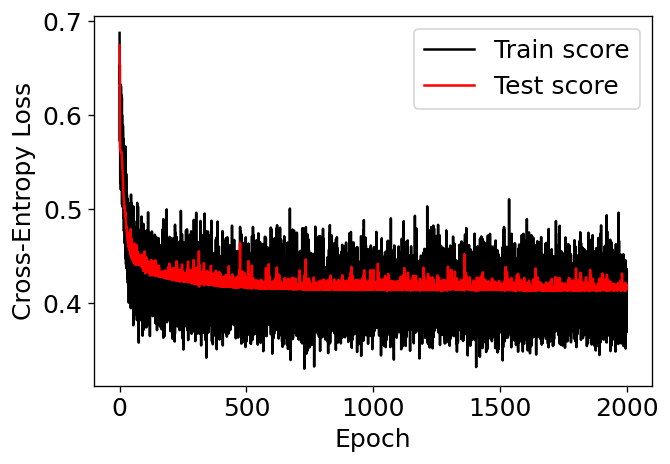

250 0.8861480075901328 0.6435059730544636
500 0.8937381404174574 0.6536582573184229
750 0.8956356736242884 0.6611770543109041
1000 0.889943074003795 0.658543567039426
1250 0.8994307400379506 0.6562917445899011
1500 0.9013282732447818 0.6638105415823823
1750 0.888045540796964 0.6460440441204534
---------------------------------------------


100%|██████████| 2000/2000 [02:02<00:00, 16.30it/s]


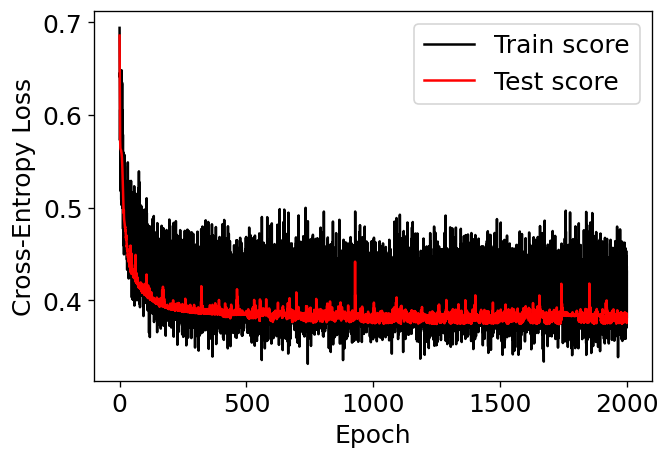

250 0.9278937381404174 0.7591122476241364
500 0.9316888045540797 0.7691691156826076
750 0.9297912713472486 0.7317659631311781
1000 0.9259962049335864 0.7466127247051639
1250 0.9468690702087287 0.799435136063509
1500 0.9278937381404174 0.7640929735506279
1750 0.9278937381404174 0.7541315216976452
---------------------------------------------


100%|██████████| 2000/2000 [01:58<00:00, 16.94it/s]


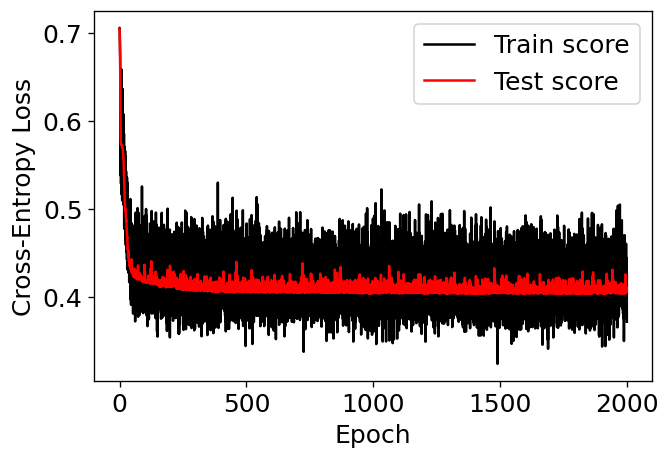

250 0.9032258064516129 0.6607950752799823
500 0.9032258064516129 0.6700289253133576
750 0.9146110056925996 0.6947266928725061
1000 0.905123339658444 0.6726062449009864
1250 0.9089184060721063 0.6777608840762442
1500 0.9070208728652751 0.6751835644886153
1750 0.9089184060721063 0.6777608840762442
---------------------------------------------


100%|██████████| 2000/2000 [01:59<00:00, 16.77it/s]


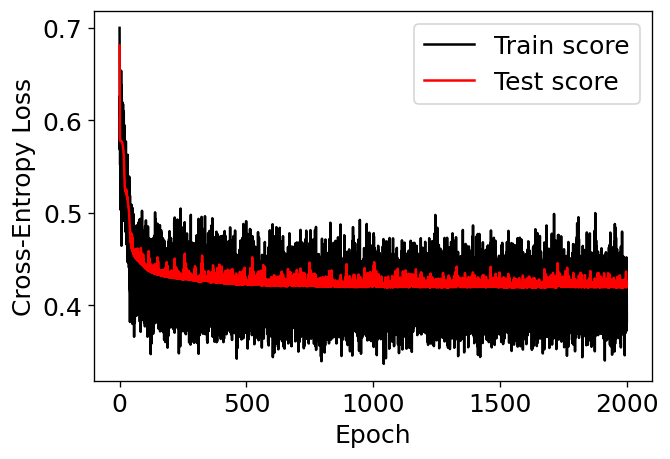

250 0.8823529411764706 0.6164082687338501
500 0.8918406072106262 0.6293281653746771
750 0.8937381404174574 0.6227943890734589
1000 0.889943074003795 0.6176264304171281
1250 0.8861480075901328 0.6215762273901809
1500 0.8842504743833017 0.6189922480620156
1750 0.8956356736242884 0.6253783684016242
---------------------------------------------


100%|██████████| 2000/2000 [02:00<00:00, 16.57it/s]


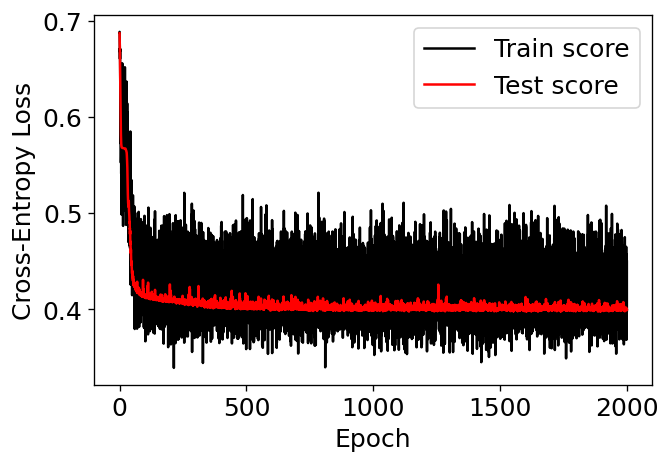

250 0.905123339658444 0.6563746154722571
500 0.9165085388994307 0.6913144202650868
750 0.9089184060721063 0.6614636739964301
1000 0.9165085388994307 0.6962325775701645
1250 0.9089184060721063 0.6762181459116631
1500 0.9165085388994307 0.6863962629600091
1750 0.9146110056925996 0.6887698910030003
---------------------------------------------
ARCH = VDFCNN_6060_CNN2_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 94.2+/-5.075431016179809
TN = 380.6+/-5.238320341483518
FP = 10.6+/-4.923413450036469
FN = 41.6+/-6.800000000000001
Acc = 0.9009487666034156+/-0.016208088428131026
TSS = 0.6672392360329379+/-0.04847117175134175
=>=>=> NUMBER OF EPOCHS: 500
TP = 95.6+/-5.003998401278722
TN = 382.6+/-4.127953488110059
FP = 8.6+/-3.5552777669262356
FN = 40.2+/-6.8527366796047255
Acc = 0.9074003795066414+/-0.014960457946434148
TSS = 0.6826997767908304+/-0.04775698459106653
=>=>=> NUMBER OF EPOCHS: 750
TP = 93.6+/-3.826225293941798
TN = 385.2+/-4.707440918375927
FP = 6.0+/-4.604345773288535
FN = 42.2+/-5.268

In [22]:
# NETWORK: VDFCNN_6060_CNN2_CONN1
ARCH = 'VDFCNN_6060_CNN2_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN2_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:45<00:00, 18.91it/s]


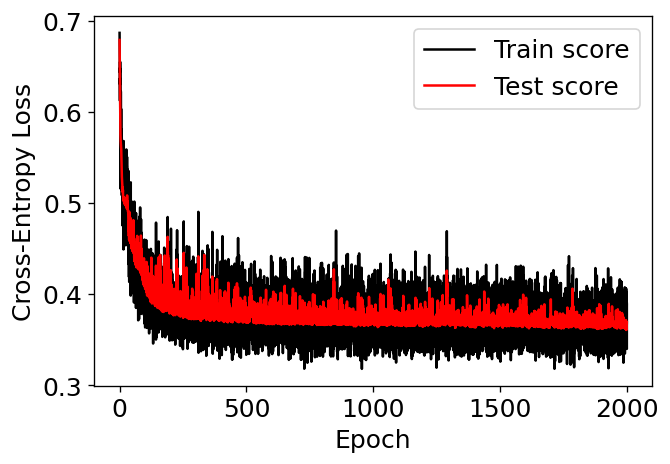

250 0.9411764705882353 0.8117438265715049
500 0.9468690702087287 0.8143773138429831
750 0.9449715370018975 0.8068585168505019
1000 0.9354838709677419 0.7991488874470439
1250 0.9392789373814042 0.8191672073584978
1500 0.9468690702087287 0.8343002175489485
1750 0.9468690702087287 0.8243387656959658
---------------------------------------------


100%|██████████| 2000/2000 [01:48<00:00, 18.50it/s]


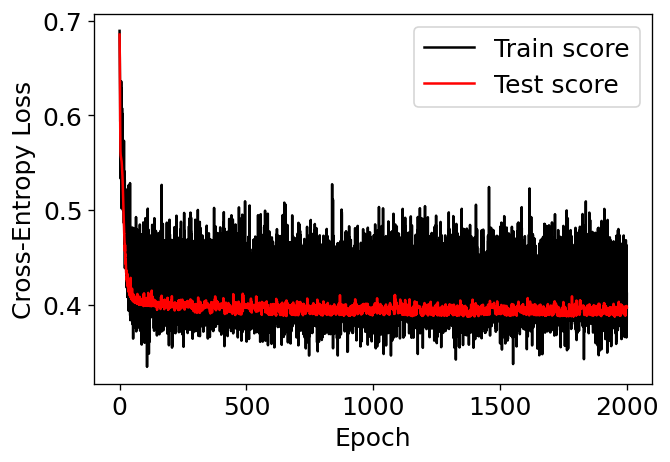

250 0.9127134724857685 0.6890004198313041
500 0.9184060721062619 0.7065760848822563
750 0.9259962049335864 0.7217090950727072
1000 0.9184060721062619 0.7115568108087478
1250 0.9184060721062619 0.7065760848822563
1500 0.920303605313093 0.6941719781687722
1750 0.9127134724857685 0.6890004198313041
---------------------------------------------


100%|██████████| 2000/2000 [01:47<00:00, 18.65it/s]


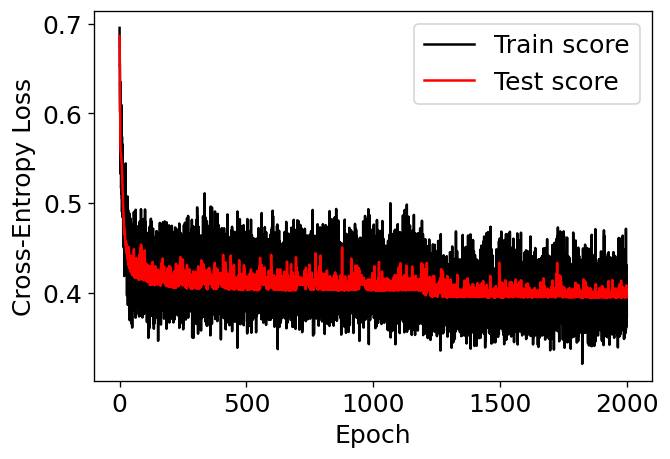

250 0.9013282732447818 0.6536008306756655
500 0.9032258064516129 0.6654120002966698
750 0.9089184060721063 0.6777608840762442
1000 0.9032258064516129 0.6654120002966698
1250 0.9089184060721063 0.7008455091596826
1500 0.9089184060721063 0.6777608840762442
1750 0.9127134724857685 0.682915523251502
---------------------------------------------


100%|██████████| 2000/2000 [01:42<00:00, 19.60it/s]


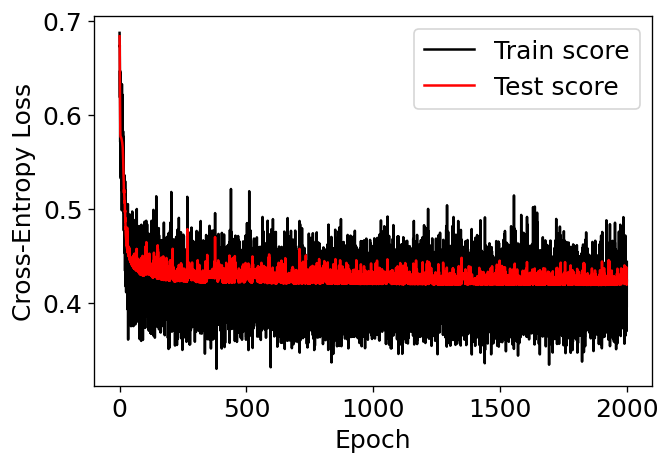

250 0.889943074003795 0.6039497969730528
500 0.888045540796964 0.6150424510889627
750 0.8785578747628083 0.6112403100775194
1000 0.8918406072106262 0.6293281653746771
1250 0.8956356736242884 0.6253783684016242
1500 0.8937381404174574 0.6227943890734589
1750 0.8918406072106262 0.6293281653746771
---------------------------------------------


100%|██████████| 2000/2000 [01:41<00:00, 19.70it/s]


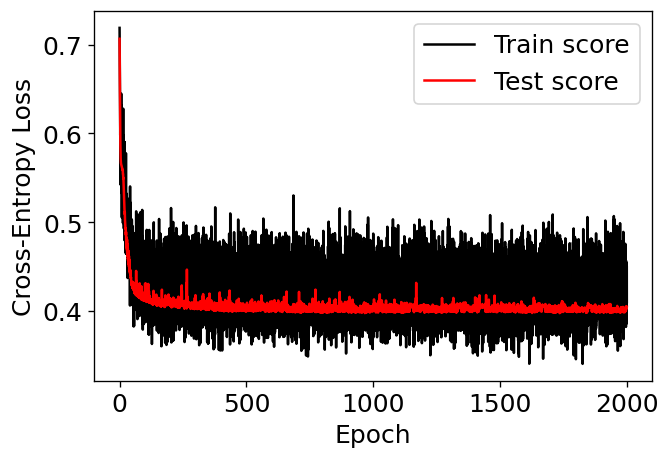

250 0.9032258064516129 0.6735027154304812
500 0.9070208728652751 0.6785917739546542
750 0.9127134724857685 0.6813072044358361
1000 0.9108159392789373 0.6836808324788273
1250 0.9127134724857685 0.6763890471307584
1500 0.9146110056925996 0.6838517336979226
1750 0.9108159392789373 0.6689263605635942
---------------------------------------------
ARCH = VDFCNN_6060_CNN1_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 95.6+/-8.260750571225353
TN = 383.8+/-1.9390719429665317
FP = 7.4+/-2.4166091947189146
FN = 40.2+/-10.552724766618335
Acc = 0.9096774193548388+/-0.01733311156989638
TSS = 0.6863595178964017+/-0.06893183631051954
=>=>=> NUMBER OF EPOCHS: 500
TP = 96.8+/-7.025667228100118
TN = 384.2+/-3.867815921162743
FP = 7.0+/-1.4142135623730951
FN = 39.0+/-9.273618495495704
Acc = 0.9127134724857685+/-0.0196465716972217
TSS = 0.6959999248131051+/-0.06620851726125321
=>=>=> NUMBER OF EPOCHS: 750
TP = 97.2+/-6.273754856543248
TN = 384.6+/-6.829348431585549
FP = 6.6+/-4.2708313008125245
FN = 38.6+/-8.404

In [23]:
# NETWORK: VDFCNN_6060_CNN1_CONN2
ARCH = 'VDFCNN_6060_CNN1_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:43<00:00, 19.41it/s]


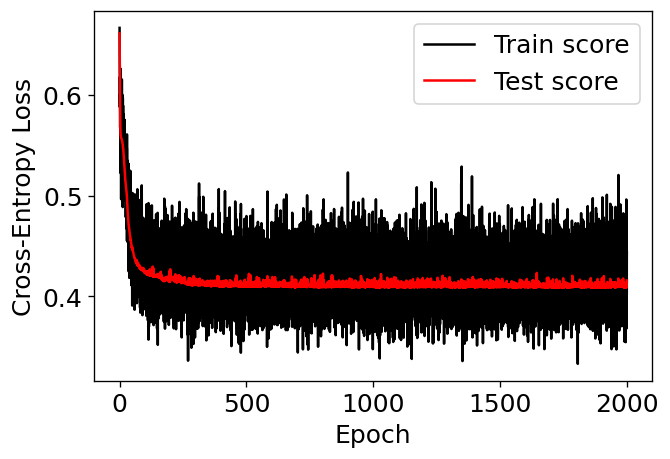

250 0.8994307400379506 0.6463302927369184
500 0.9013282732447818 0.6488683638029084
750 0.9089184060721063 0.6689820999198504
1000 0.905123339658444 0.6489637800083966
1250 0.9070208728652751 0.6564825770008779
1500 0.8975332068311196 0.6537536735239113
1750 0.9032258064516129 0.6414449830159155
---------------------------------------------


100%|██████████| 2000/2000 [01:43<00:00, 19.41it/s]


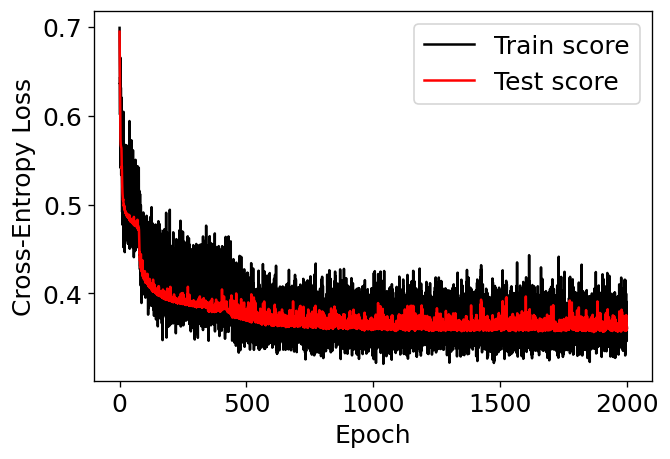

250 0.920303605313093 0.7240563337277204
500 0.9392789373814042 0.8390901110644632
750 0.937381404174573 0.8514942177779473
1000 0.9601518026565465 0.8570474409373688
1250 0.9468690702087287 0.8542231212549138
1500 0.9468690702087287 0.8442616694019311
1750 0.9487666034155597 0.8467997404679211
---------------------------------------------


100%|██████████| 2000/2000 [01:46<00:00, 18.79it/s]


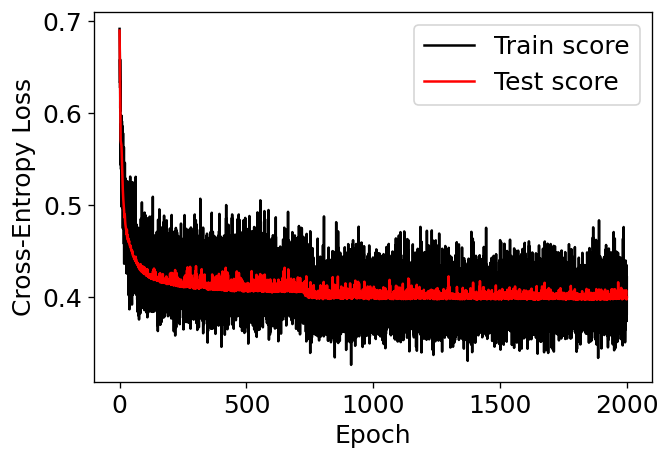

250 0.905123339658444 0.6772231699176741
500 0.9070208728652751 0.6798004895053029
750 0.9184060721062619 0.7044982570644516
1000 0.920303605313093 0.7209263517021435
1250 0.9165085388994307 0.7019209374768227
1500 0.9184060721062619 0.7091151820811392
1750 0.9222011385199241 0.7235036712897723
---------------------------------------------


100%|██████████| 2000/2000 [01:42<00:00, 19.51it/s]


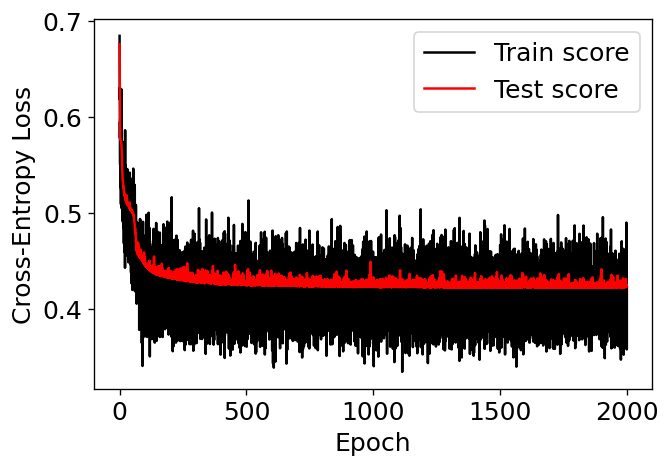

250 0.8823529411764706 0.5890550018456995
500 0.888045540796964 0.6150424510889627
750 0.8918406072106262 0.6202104097452934
1000 0.889943074003795 0.6130675526024363
1250 0.8975332068311196 0.6370801033591732
1500 0.8937381404174574 0.6227943890734589
1750 0.8918406072106262 0.6293281653746771
---------------------------------------------


100%|██████████| 2000/2000 [01:41<00:00, 19.70it/s]


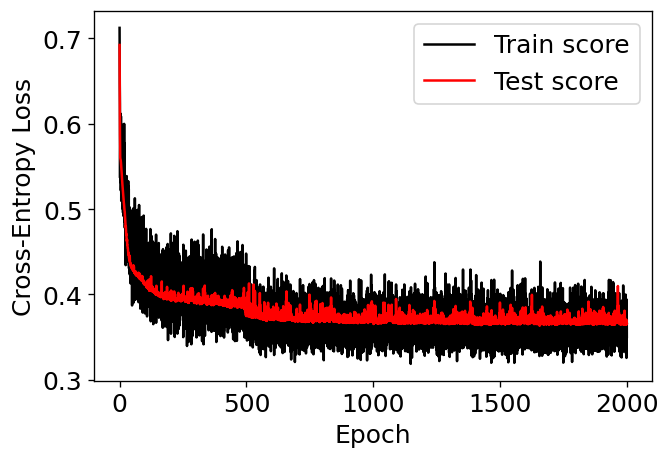

250 0.920303605313093 0.7505032091451141
500 0.9335863377609108 0.8322509589457293
750 0.9354838709677419 0.8298773309027382
1000 0.9468690702087287 0.835308191865102
1250 0.9449715370018975 0.8327636626030155
1500 0.9449715370018975 0.8130910333827047
1750 0.9430740037950665 0.8548099198663173
---------------------------------------------
ARCH = VDFCNN_6060_CNN1_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 95.0+/-7.155417527999327
TN = 382.2+/-2.7129319932501073
FP = 9.0+/-2.0976176963403033
FN = 40.8+/-8.930845424706442
Acc = 0.9055028462998103+/-0.014220109294265806
TSS = 0.6774336014746253+/-0.05708079133317301
=>=>=> NUMBER OF EPOCHS: 500
TP = 102.0+/-12.992305415129373
TN = 379.6+/-3.9293765408777004
FP = 11.6+/-4.923413450036469
FN = 33.8+/-14.837789592793127
Acc = 0.9138519924098674+/-0.01952155013223786
TSS = 0.7230104748814732+/-0.09426474943267342
=>=>=> NUMBER OF EPOCHS: 750
TP = 103.2+/-12.967652061957862
TN = 380.8+/-5.268775948927796
FP = 10.4+/-6.770524351924303
FN = 32.6+/-

In [24]:
# NETWORK: VDFCNN_6060_CNN1_CONN1
ARCH = 'VDFCNN_6060_CNN1_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

## Best Network Architecture

CONCLUSION:

Best network configuration: VDFCNN_6060_CNN1_CONN1 with 1000 epochs

Running for the best configuration now...

100%|██████████| 1000/1000 [01:09<00:00, 14.48it/s]


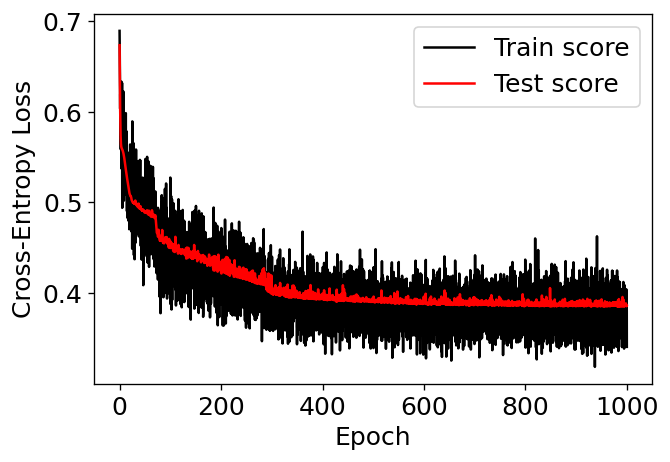

0.9297912713472486 -1
0.9297912713472486 0.7467081409106523
---------------------------------------------


100%|██████████| 1000/1000 [00:52<00:00, 19.08it/s]


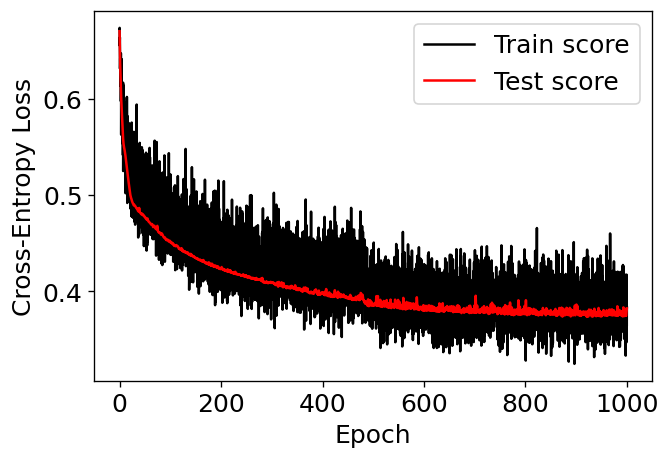

0.9316888045540797 -1
0.9316888045540797 0.7641883897561161
---------------------------------------------


100%|██████████| 1000/1000 [00:53<00:00, 18.80it/s]


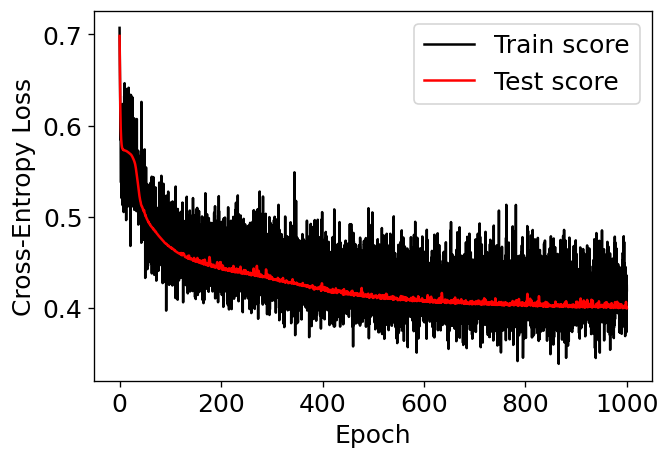

0.9184060721062619 -1
0.9184060721062619 0.6998813320477638
---------------------------------------------


100%|██████████| 1000/1000 [00:52<00:00, 18.89it/s]


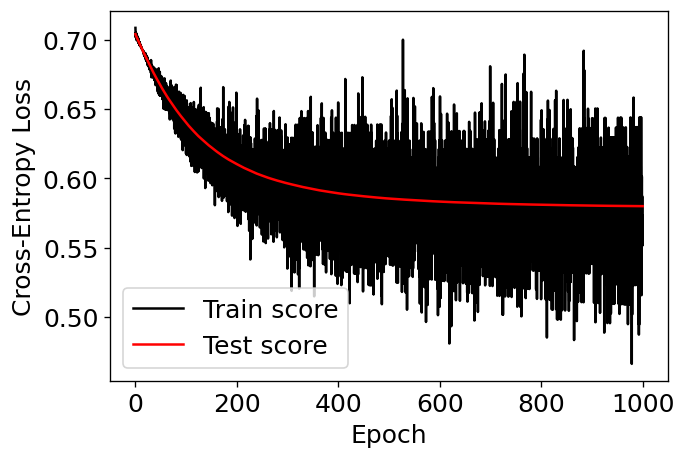

<ipython-input-10-be7d2eddc1a2>:3: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


0.7343453510436433 -1
RERUNNING THE SAMPLE...


100%|██████████| 1000/1000 [00:53<00:00, 18.62it/s]


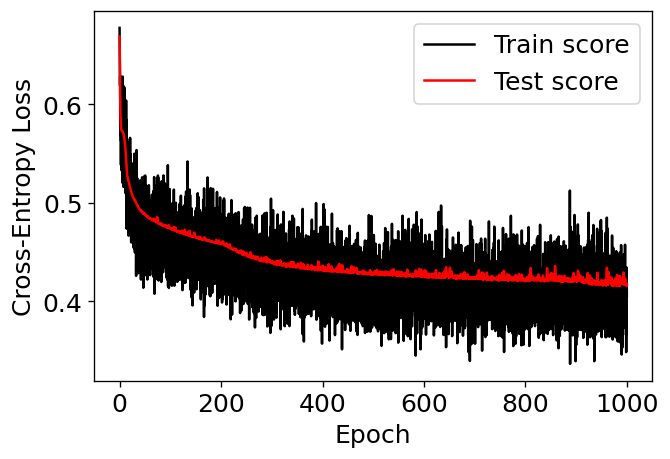

0.8994307400379506 -1
0.8994307400379506 0.6396640826873385
---------------------------------------------


100%|██████████| 1000/1000 [00:53<00:00, 18.71it/s]


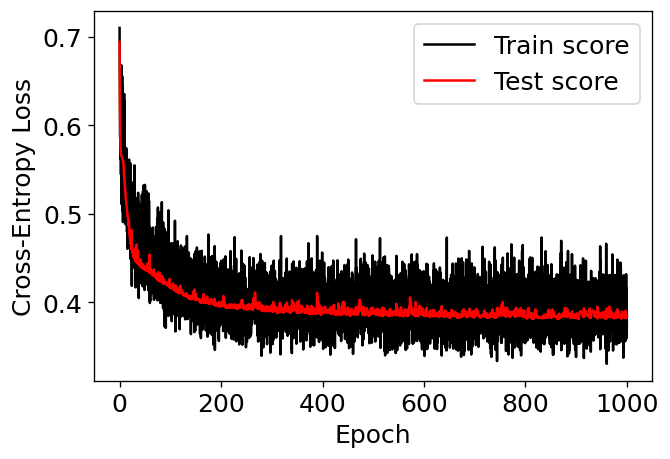

0.9278937381404174 -1
0.9278937381404174 0.7951084273290038
---------------------------------------------


100%|██████████| 1000/1000 [00:50<00:00, 19.78it/s]


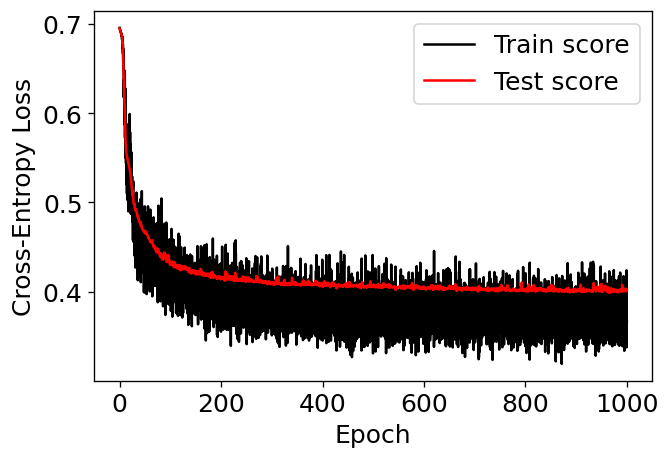

0.9070208728652751 -1
0.9070208728652751 0.6890343395386783
---------------------------------------------


100%|██████████| 1000/1000 [00:50<00:00, 19.66it/s]


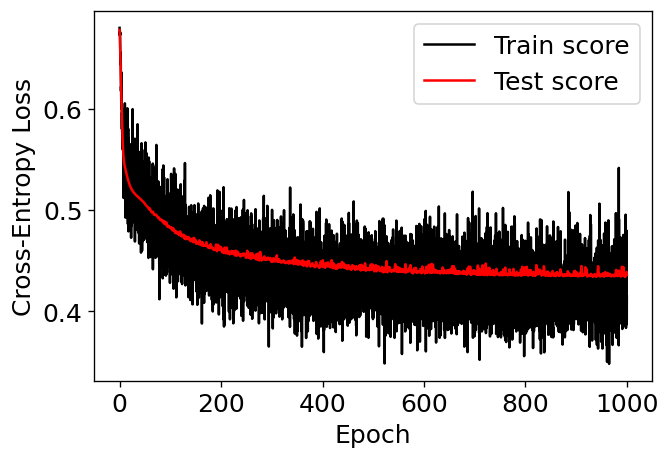

0.8785578747628083 -1
RERUNNING THE SAMPLE...


100%|██████████| 1000/1000 [00:50<00:00, 19.64it/s]


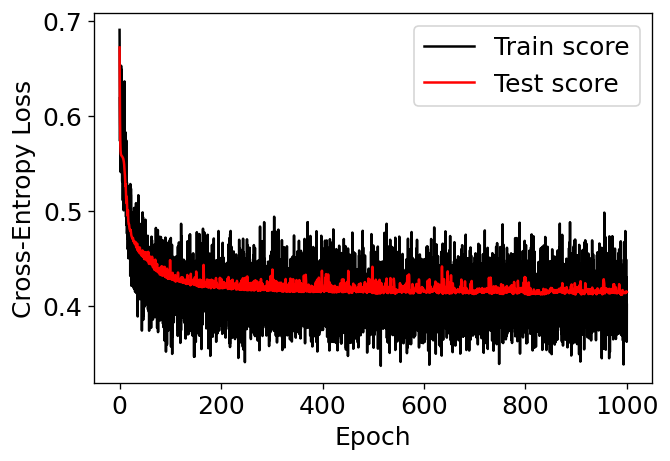

0.9013282732447818 -1
0.9013282732447818 0.620693664018601
---------------------------------------------


100%|██████████| 1000/1000 [00:50<00:00, 19.62it/s]


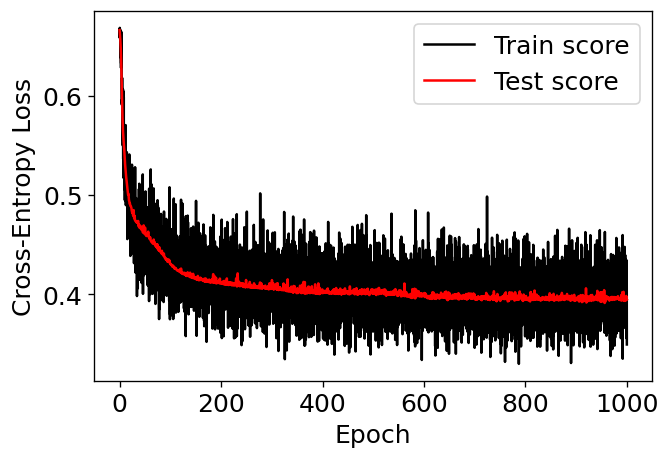

0.9165085388994307 -1
0.9165085388994307 0.711154787510198
---------------------------------------------


100%|██████████| 1000/1000 [00:51<00:00, 19.45it/s]


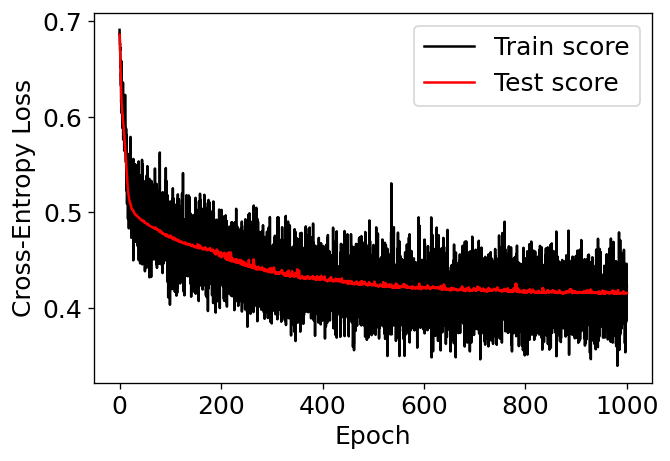

0.9013282732447818 -1
0.9013282732447818 0.607377975147053
---------------------------------------------


100%|██████████| 1000/1000 [00:51<00:00, 19.45it/s]


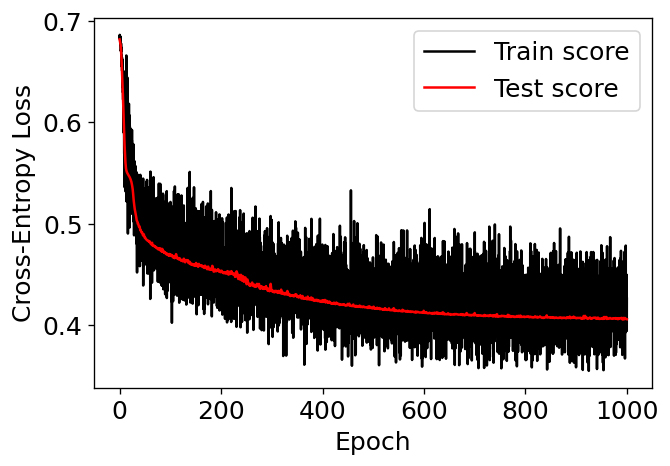

0.9089184060721063 -1
0.9089184060721063 0.6381692913385827
---------------------------------------------
ARCH = VDFCNN_6060_CNN1_CONN1
TP = 94.9+/-10.377379245262263
TN = 386.9+/-6.5337584895678535
FP = 5.8+/-3.994996871087636
FN = 39.4+/-8.83402513014311
Acc = 0.9142314990512335+/-0.01178305479792031
TSS = 0.6911980430283988+/-0.06095010355408021


In [25]:
# NETWORK: VDFCNN_6060_CNN1_CONN1
ARCH = 'VDFCNN_6060_CNN1_CONN1'

tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 1000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = -1

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

# Tests for individual runs

Implementation of early stopping is necessary here. The runs behave very active

In [ ]:
simfiles = [\
'particles.d11_A0.5Hepp_beta0.5eps1e-4_256',\
'particles.d11_A0.75Hepp_beta1_256',\
'particles.d11_E11Ap3.3Aa2.0Vd0.42',\
'particles.d11_E11Ap4.3Aa1.6',\
'particles.d11_E11Ap4.3Aa1.6Vd0.32',\
'particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256',\
'particles.d11_He++A10_256_iden0eps0',\
'particles.d11_He++v2_256_iden0eps1e-4t600',\
'particles.d11_He++vd1.5_256_iden0eps1e-4',\
'particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long',\
'particles.d11_pv1Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2a_128x3_iden0eps1e-4_dx0.75',\
'particles.d11_pv2Ap1Ab1betac0.429betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2Ap1Ab2betac0.429betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2av2.3_128x3_iden0eps1e-4_dx0.75',\
'particles.d11_pv2av2_rdna0.03375_128x3_iden0eps1e-4_dx0.75_t6000',\
'particles.d11_vap1.2Ap1Aa0.75_rdna_0.05',\
'particles.d11_vap1.2Ap3.35Aa2.05rdna_0.007',\
'particles.d11_vap1.5Ap1.5Aa1rdna_0.007',\
'particles.d11_e260945ap1.30.5_1',\
'particles.d11_e260955ap2.20.4_2',\
'particles.d11_e261013ap1.50.6_3',\
'particles.d11_e261016ap1.70.6_4',\
'particles.d11_e261019ap1.50.4_5',\
'particles.d11_e261022ap1.40.4_6',\
'particles.d11_e261040ap1.40.4_7',\
'particles.d11_pv1.4av2Ap2Apb2betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2Ap2Apb2beta_pb0.429_128_128x2_dx0.75',\
'particles.d11_pv2av1.4Ap1Aa1betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2av1.4Ap2Aa2betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2av1.4Ap2Ab2beta0.429_128_128x4_dx0.75_t3000',\
'particles.d11_pv2av2Ap1Aa1beta0.429_128_128x4_dx0.75_t3000',\
'particles.d11_pv2av2Ap2Aa2beta0.429_128_128x4_dx0.75_t3000']

In [ ]:
def outputclass_analysis_scorereturn_spec(test_labels, predicted_labels):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(test_labels)):
        if ( (test_labels[i] == 0) and (predicted_labels[i] == 0) ): tn += 1
        if ( (test_labels[i] == 0) and (predicted_labels[i] == 1) ): fp += 1
        if ( (test_labels[i] == 1) and (predicted_labels[i] == 0) ): fn += 1
        if ( (test_labels[i] == 1) and (predicted_labels[i] == 1) ): tp += 1
    acc = (tp+tn)/(tp+fn+fp+tn)
    if ( ((tp + fn) == 0) or ((fp + tn) == 0) ):
      tss = -1
    else:
      tss = tp/(tp+fn) - fp/(fp+tn)
    return tp, tn, fp, fn, acc, tss

100%|██████████| 1750/1750 [01:23<00:00, 20.93it/s]


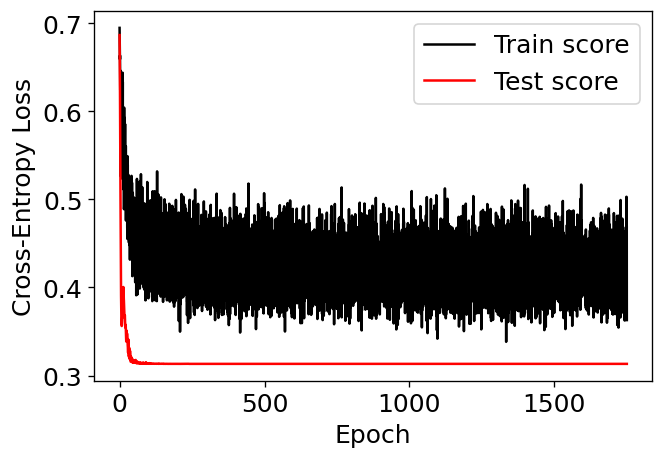

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 30.95it/s]


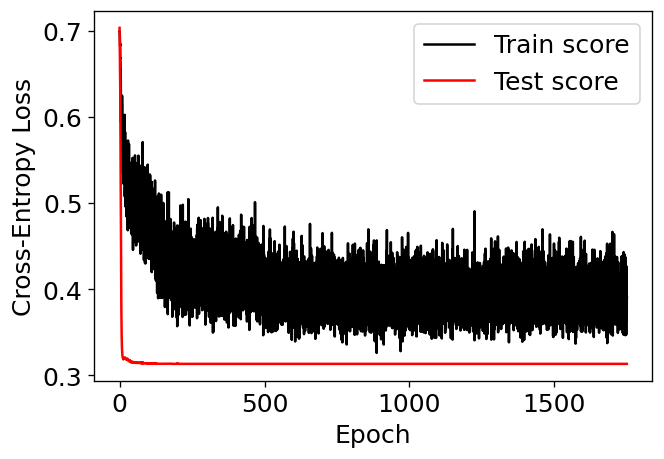

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:54<00:00, 31.92it/s]


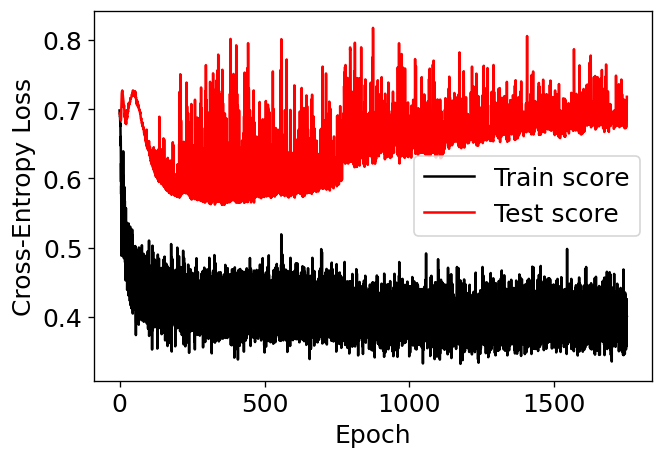

0.43478260869565216 -1
0.43478260869565216 -0.10384615384615381
---------------------------------------------


100%|██████████| 1750/1750 [00:54<00:00, 32.22it/s]


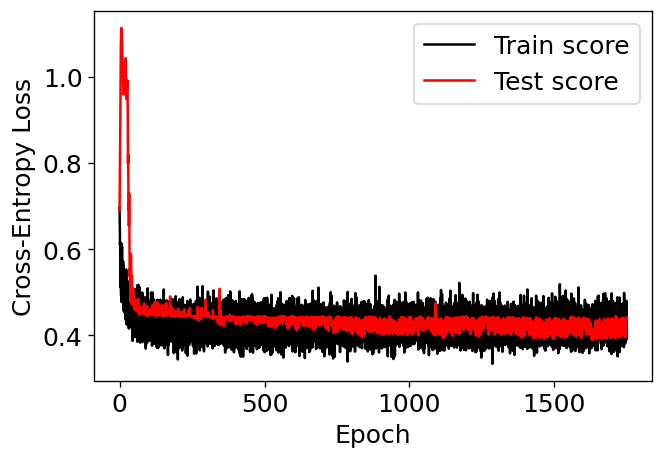

0.8695652173913043 -1
0.8695652173913043 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.43it/s]


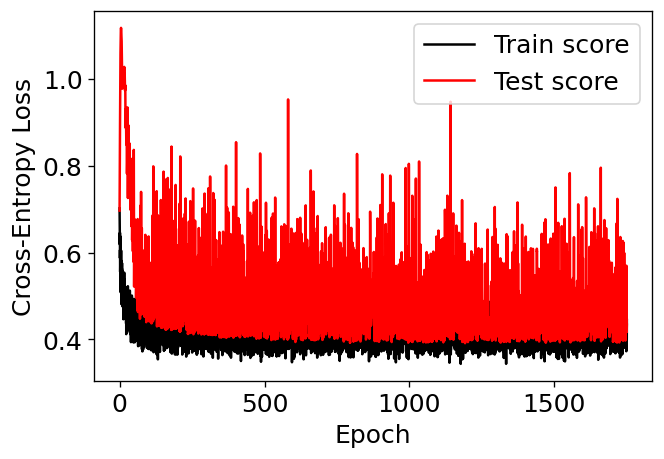

0.9347826086956522 -1
0.9347826086956522 0.926829268292683
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.57it/s]


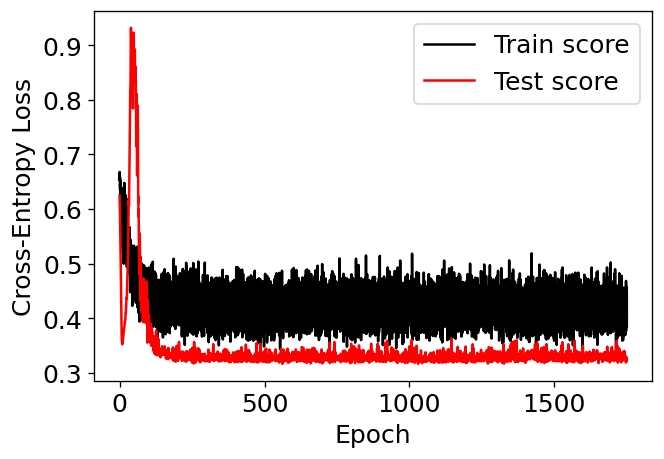

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.54it/s]


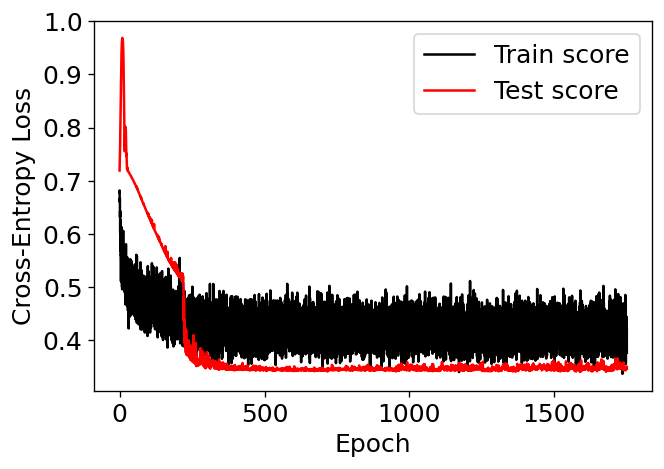

0.9782608695652174 -1
0.9782608695652174 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.59it/s]


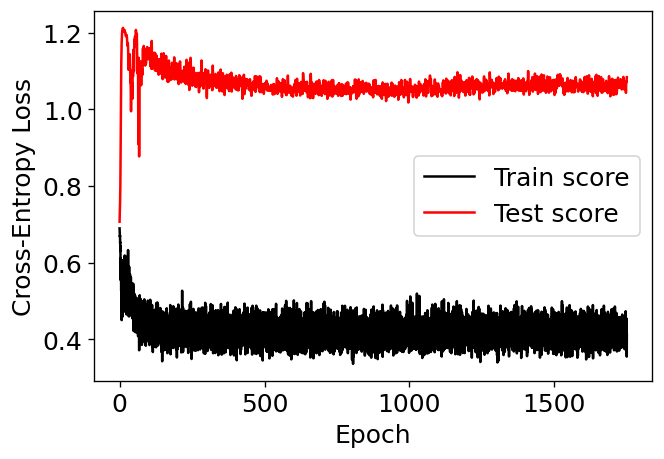

0.2222222222222222 -1
0.2222222222222222 0.16666666666666666
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.55it/s]


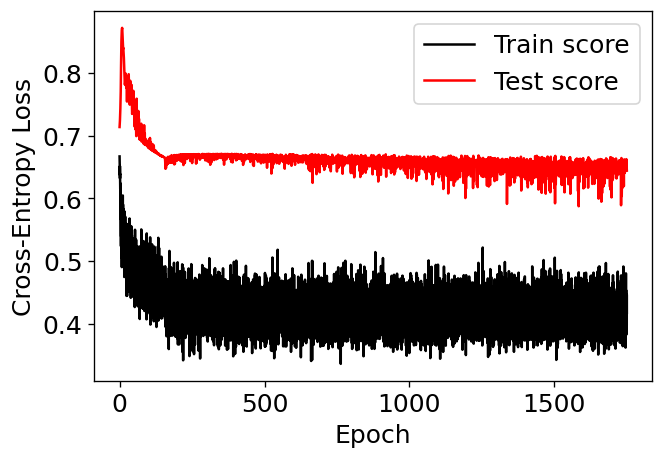

0.6410256410256411 -1
0.6410256410256411 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.49it/s]


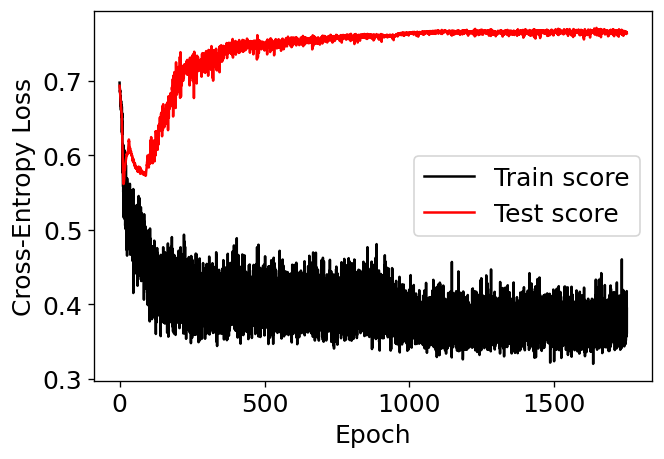

0.5135135135135135 -1
0.5135135135135135 -0.2094943240454076
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.63it/s]


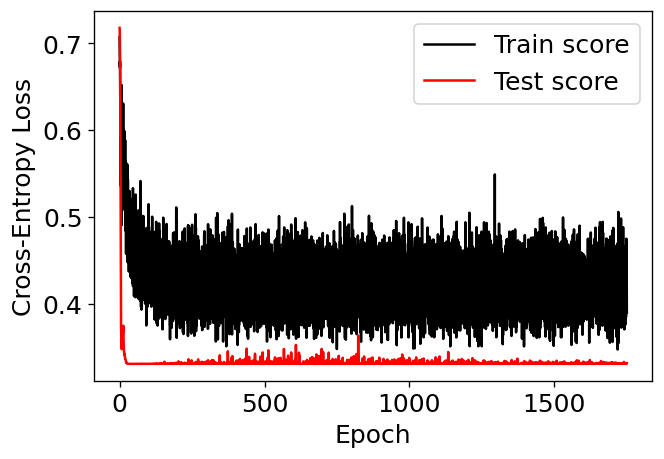

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.76it/s]


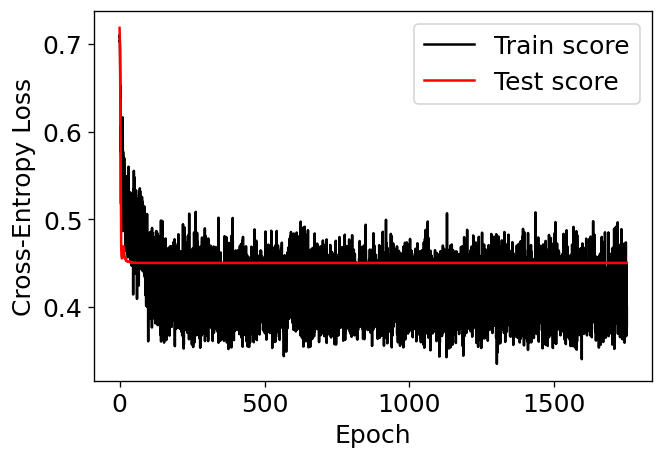

0.863013698630137 -1
0.863013698630137 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.40it/s]


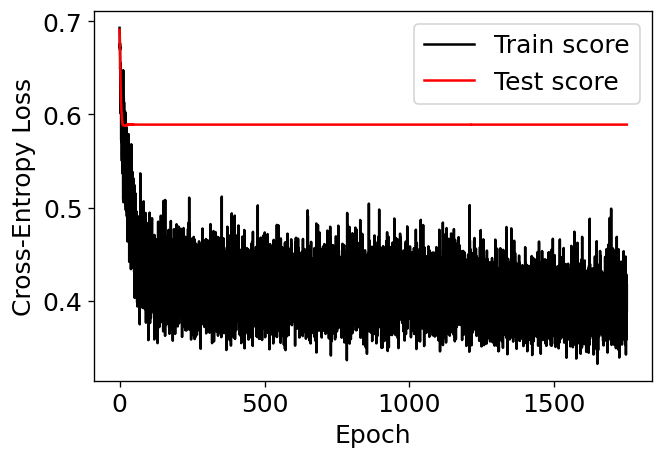

0.7241379310344828 -1
0.7241379310344828 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.50it/s]


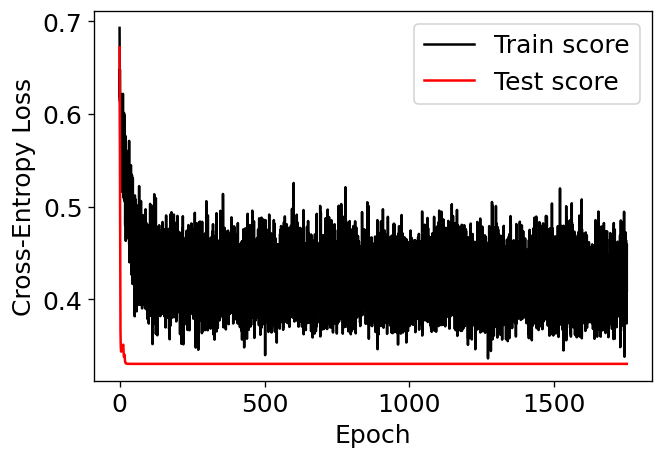

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.73it/s]


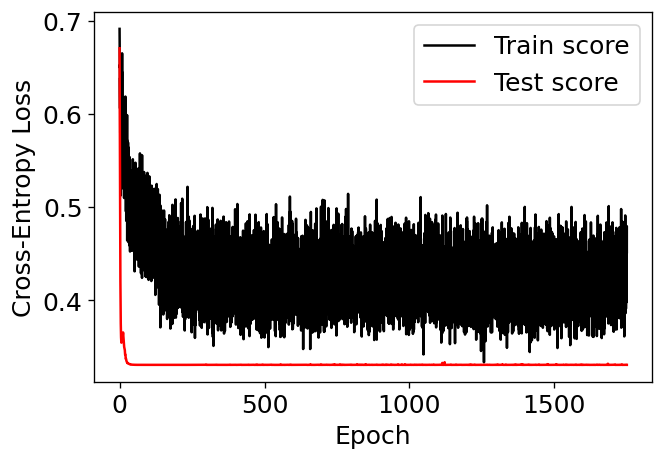

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.41it/s]


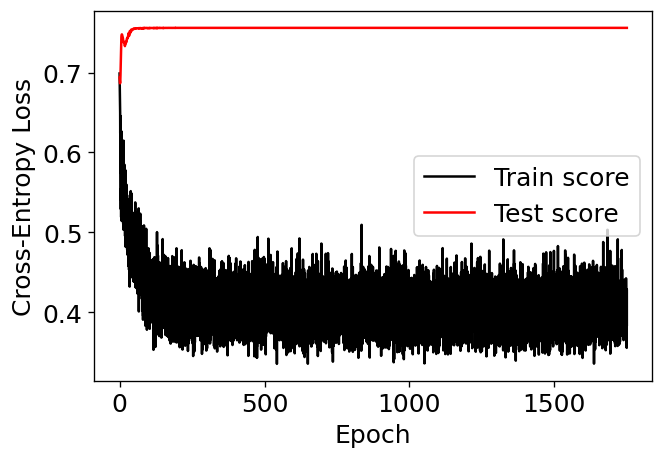

0.5573770491803278 -1
0.5573770491803278 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.38it/s]


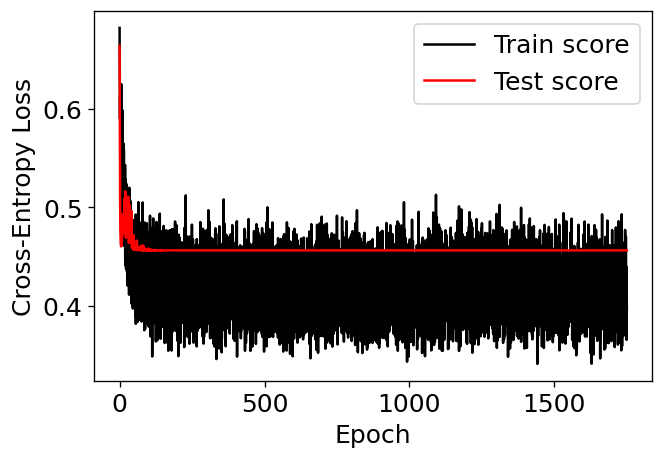

0.8571428571428571 -1
0.8571428571428571 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.18it/s]


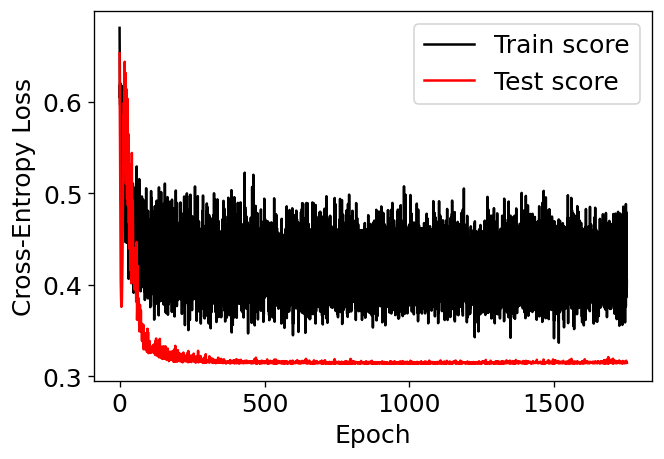

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.50it/s]


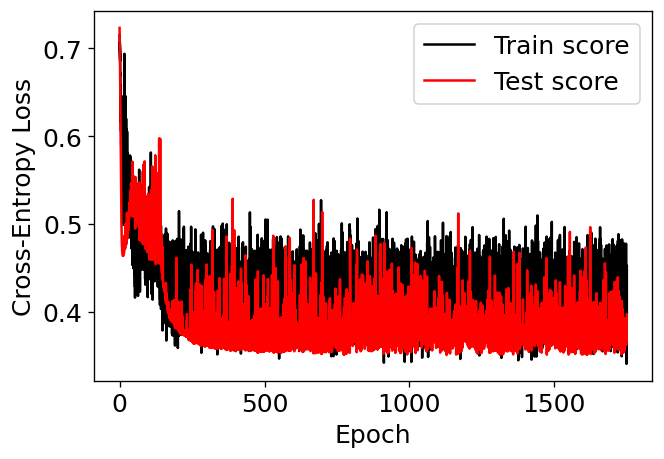

0.9090909090909091 -1
0.9090909090909091 0.8947368421052632
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.12it/s]


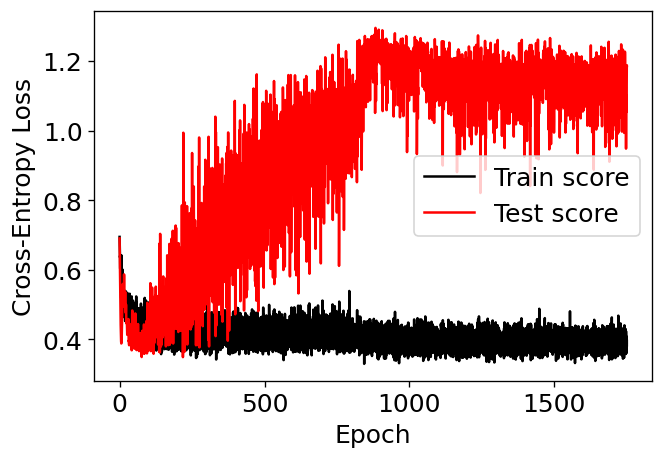

0.0 -1
0.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.09it/s]


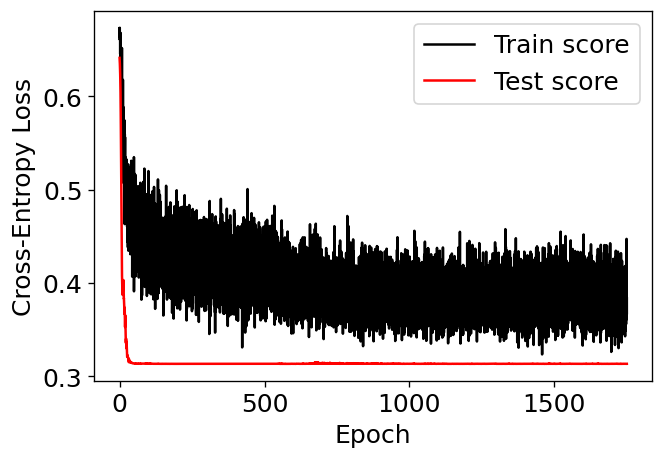

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.20it/s]


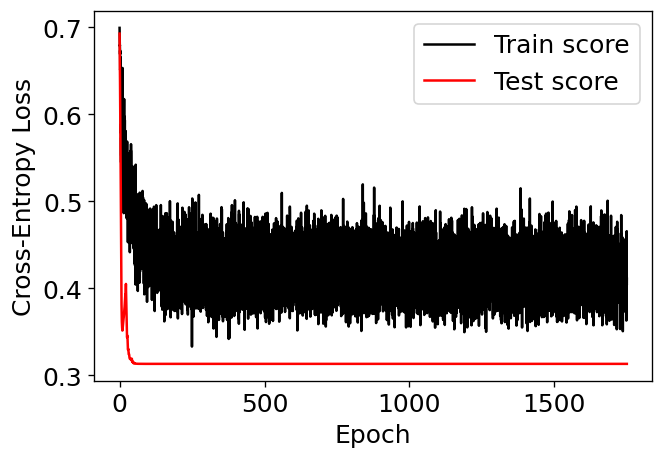

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.10it/s]


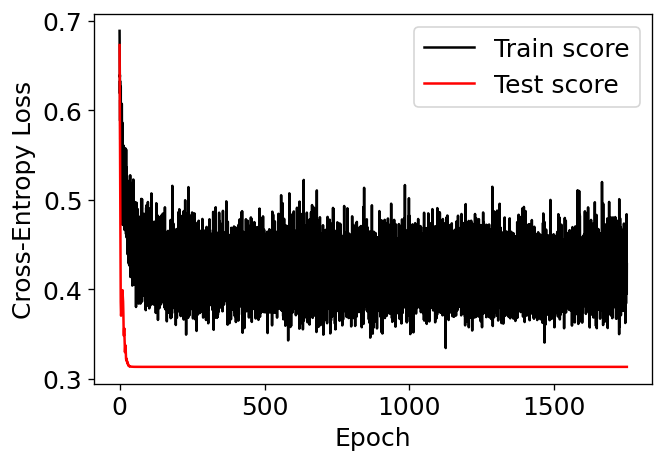

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.36it/s]


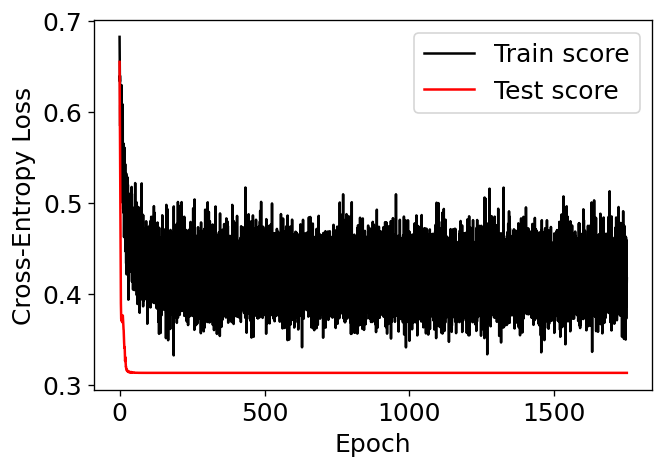

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.67it/s]


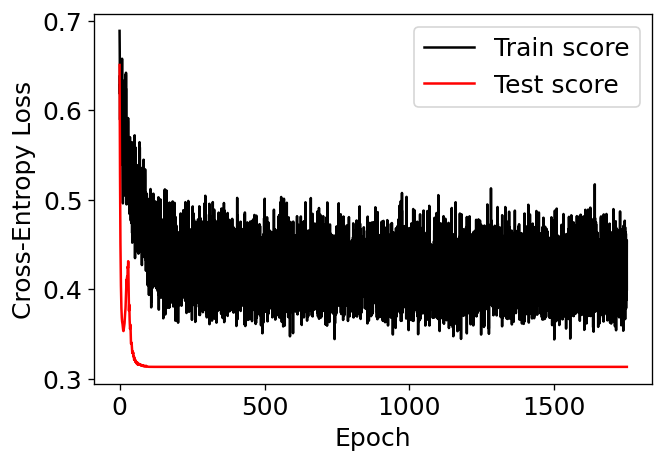

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.23it/s]


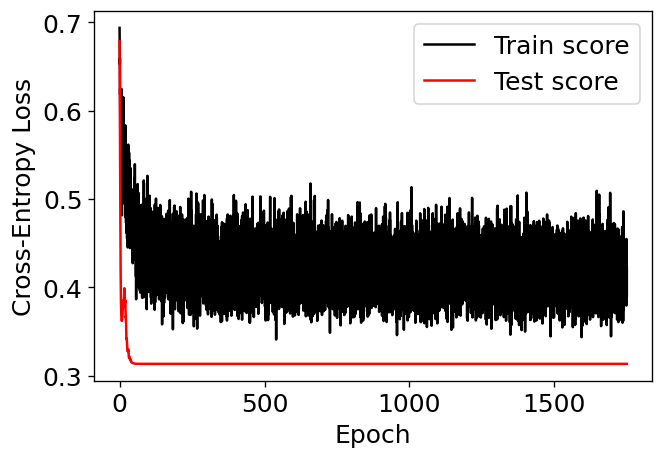

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 30.80it/s]


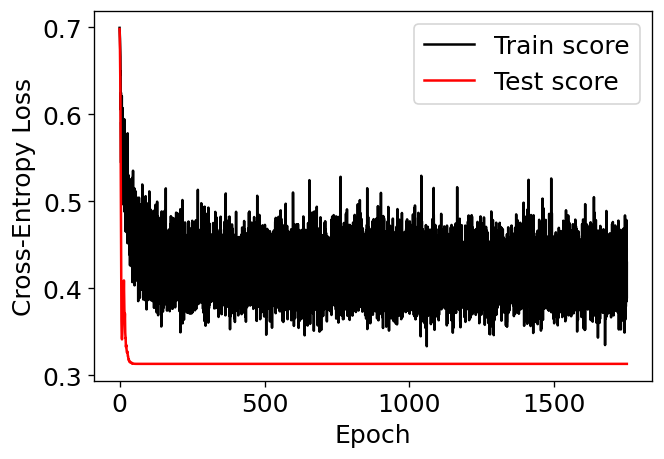

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 30.77it/s]


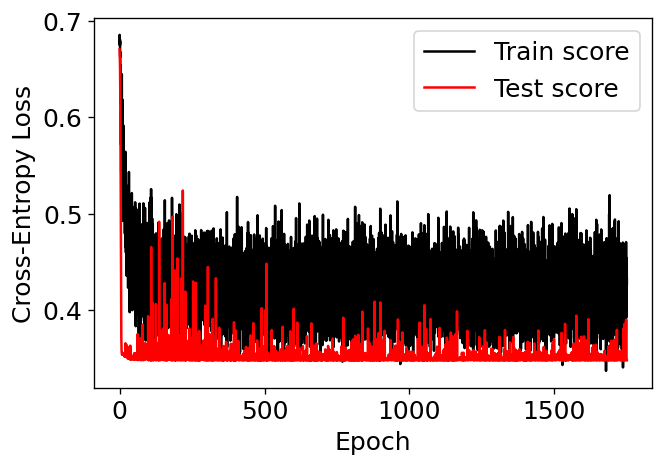

0.9655172413793104 -1
0.9655172413793104 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.15it/s]


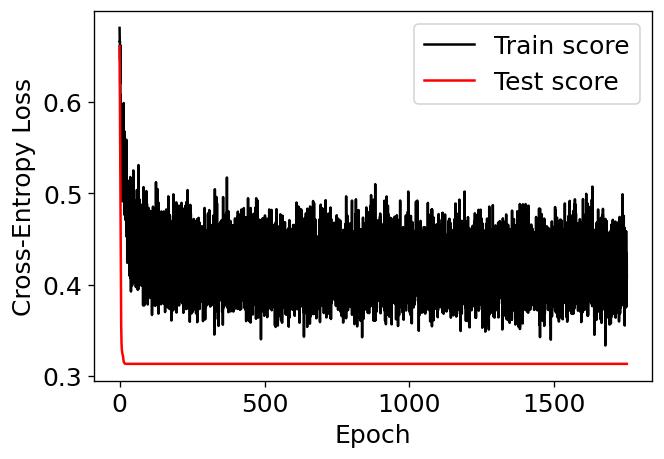

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.38it/s]


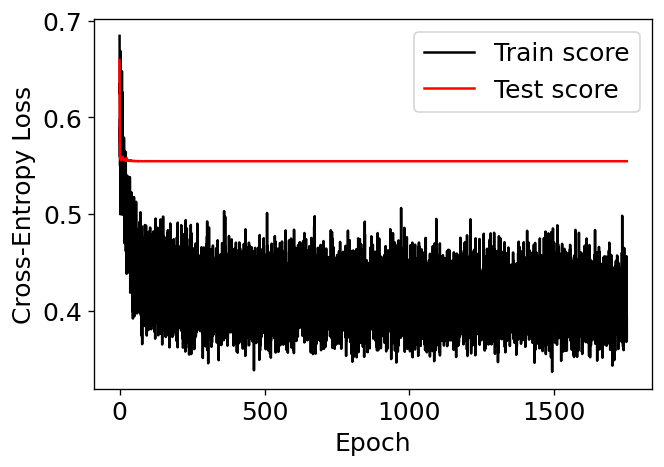

0.7586206896551724 -1
0.7586206896551724 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 30.81it/s]


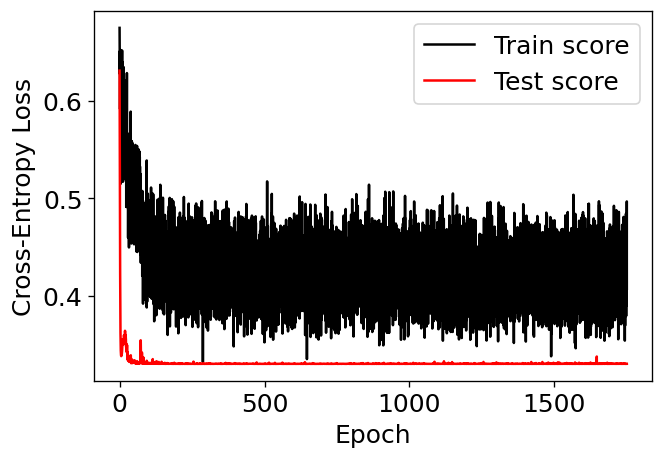

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.09it/s]


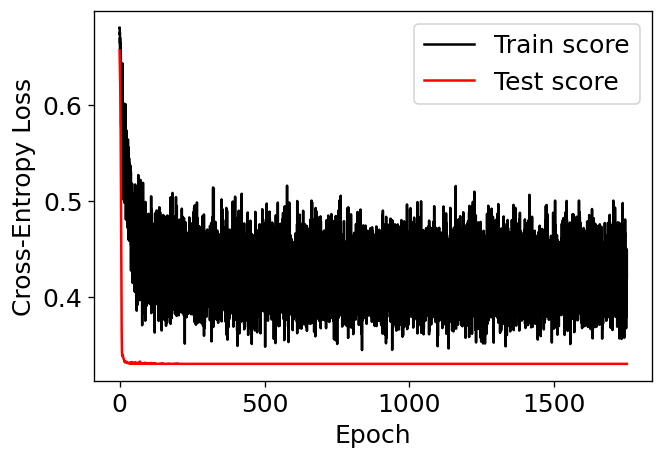

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.22it/s]


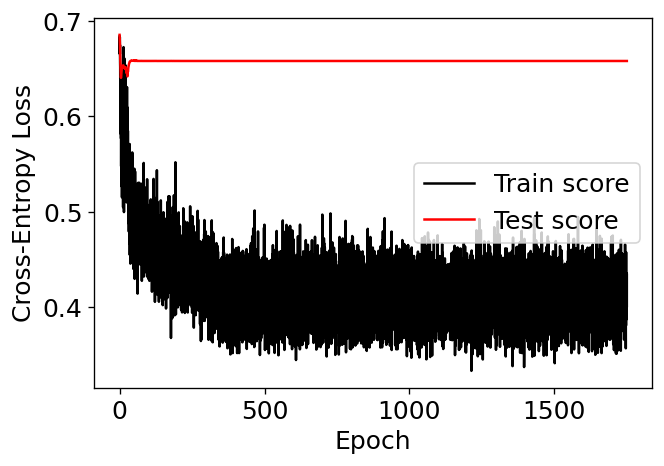

0.6551724137931034 -1
0.6551724137931034 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.09it/s]


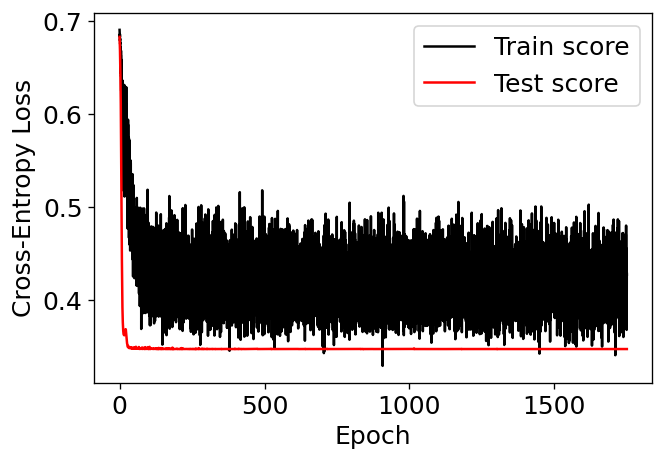

0.9655172413793104 -1
0.9655172413793104 0.0
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN1
TP = 6.088235294117647+/-14.007073102037168
TN = 30.88235294117647+/-23.553149790461212
FP = 3.764705882352941+/-10.099676242712558
FN = 6.205882352941177+/-13.485895489830467
Acc = 0.8459863475247967+/-0.24287978941619812
TSS = -0.33309140296549844+/-0.5680130531234785
[1.         1.         0.43478261 0.86956522 0.93478261 1.
 0.97826087 0.22222222 0.64102564 0.51351351 0.98275862 0.8630137
 0.72413793 0.98275862 0.98275862 0.55737705 0.85714286 1.
 0.90909091 0.         1.         1.         1.         1.
 1.         1.         1.         0.96551724 1.         0.75862069
 0.98275862 0.98275862 0.65517241 0.96551724]
[-1.         -1.         -0.10384615  0.          0.92682927 -1.
  0.          0.16666667  0.         -0.20949432  0.          0.
  0.          0.          0.          0.          0.         -1.
  0.89473684 -1.         -1.         -1.         -1.     

In [ ]:
# NETWORK: VDFCNN_4040_CNN1_CONN1
ARCH = 'VDFCNN_4040_CNN1_CONN1'

tp = np.zeros([34], dtype=int)
tn = np.zeros([34], dtype=int)
fp = np.zeros([34], dtype=int)
fn = np.zeros([34], dtype=int)
acc = np.zeros([34], dtype=float)
tss = np.zeros([34], dtype=float)

for n_e, simfile in enumerate(simfiles):

  train_index = np.where(simnames != simfile)[0]
  test_index = np.where(simnames == simfile)[0]

  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 1750
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = -1

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn_spec(f_test, labels_optim)

    print(_acc, optim_index)
    #if (_acc < 0.88):
      #print("RERUNNING THE SAMPLE...")
      #continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn_spec(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

print(acc)

print(tss)

100%|██████████| 1250/1250 [01:00<00:00, 20.71it/s]


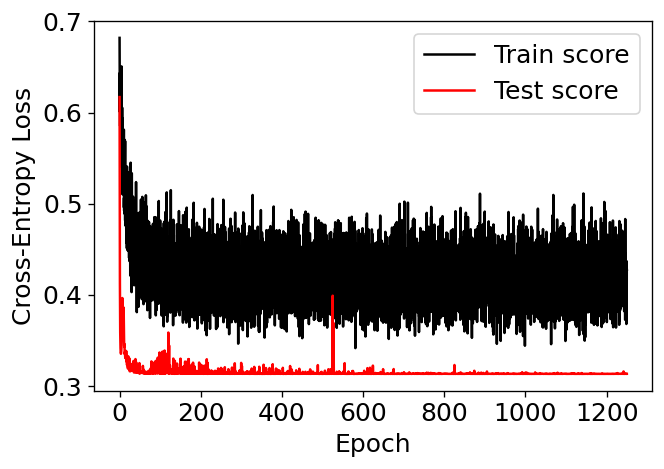

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1250/1250 [01:01<00:00, 20.24it/s]


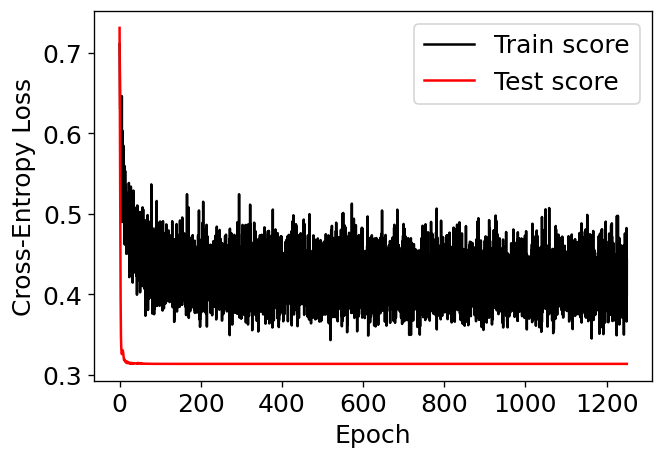

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1250/1250 [01:01<00:00, 20.24it/s]


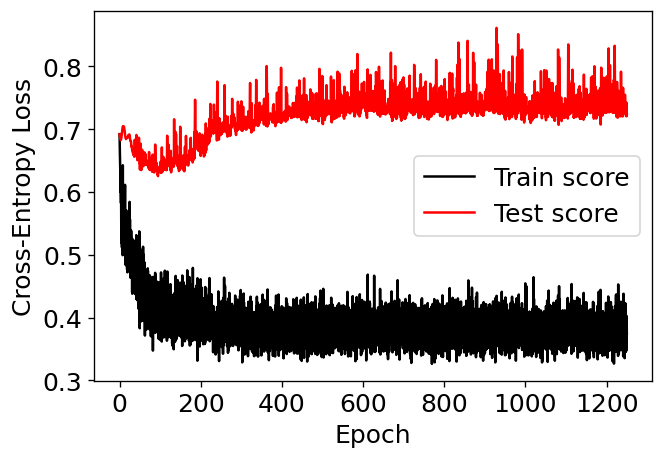

0.5652173913043478 -1
0.5652173913043478 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:02<00:00, 19.90it/s]


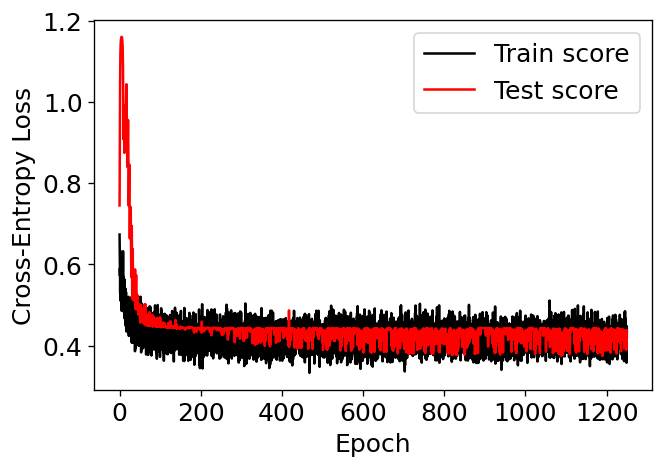

0.8695652173913043 -1
0.8695652173913043 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:02<00:00, 19.95it/s]


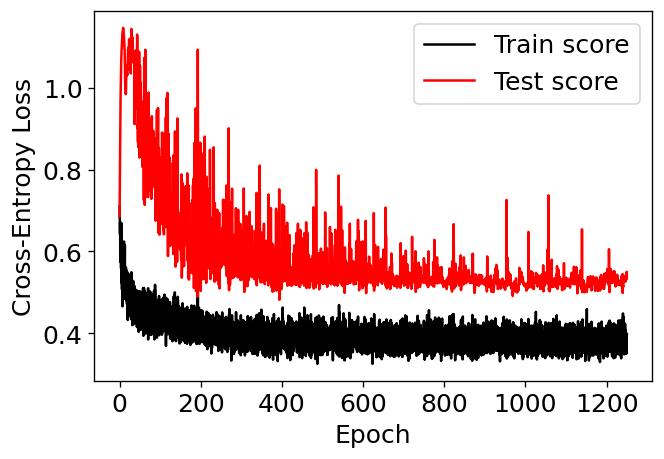

0.7608695652173914 -1
0.7608695652173914 0.029268292682926744
---------------------------------------------


100%|██████████| 1250/1250 [00:58<00:00, 21.19it/s]


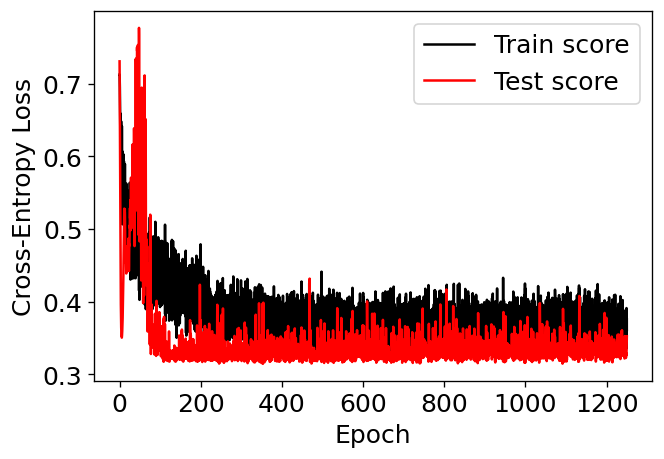

0.9583333333333334 -1
0.9583333333333334 -1.0
---------------------------------------------


100%|██████████| 1250/1250 [01:01<00:00, 20.17it/s]


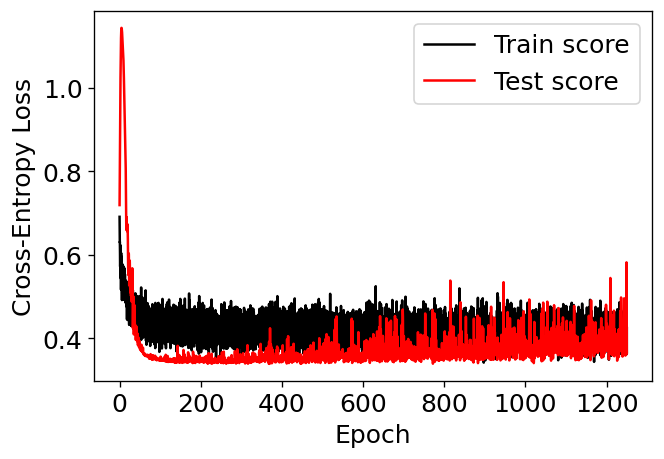

0.9782608695652174 -1
0.9782608695652174 0.0
---------------------------------------------


100%|██████████| 1250/1250 [00:57<00:00, 21.70it/s]


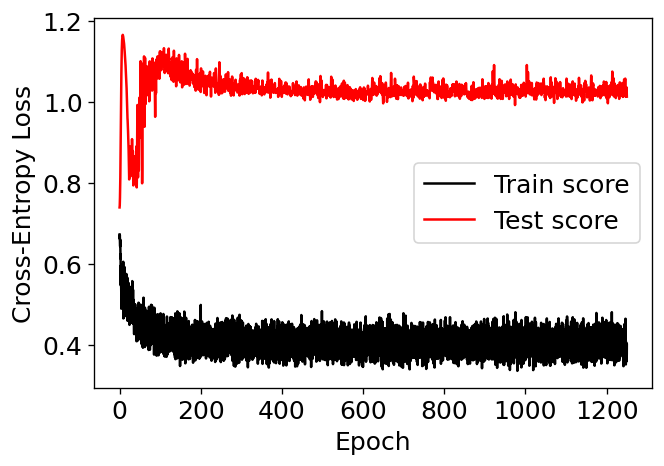

0.3 -1
0.3 0.25
---------------------------------------------


100%|██████████| 1250/1250 [01:00<00:00, 20.81it/s]


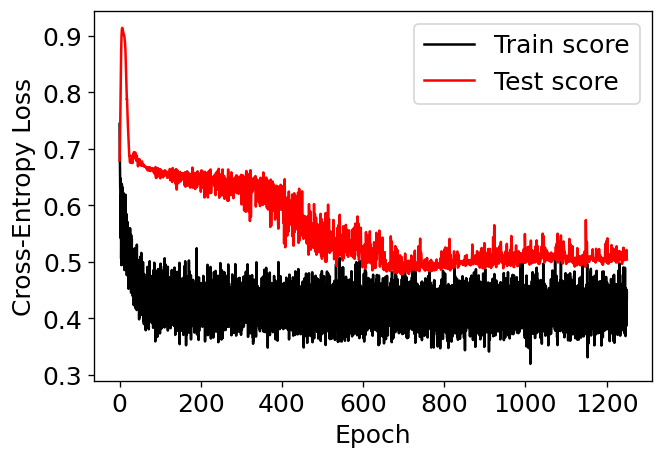

0.8589743589743589 -1
0.8589743589743589 0.7642857142857143
---------------------------------------------


100%|██████████| 1250/1250 [00:58<00:00, 21.21it/s]


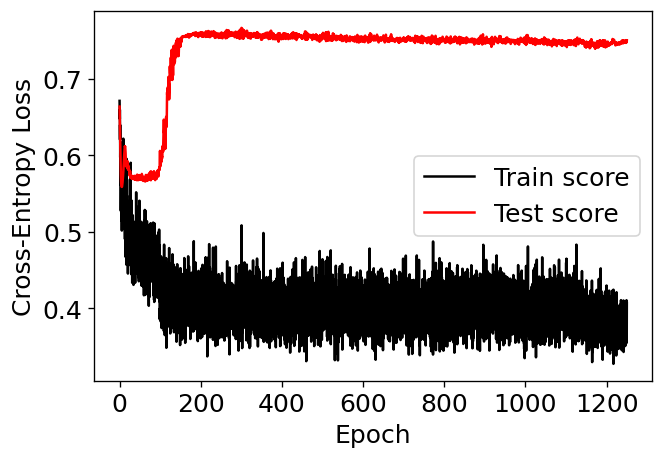

0.5472972972972973 -1
0.5472972972972973 -0.062435500515995834
---------------------------------------------


100%|██████████| 1250/1250 [01:01<00:00, 20.26it/s]


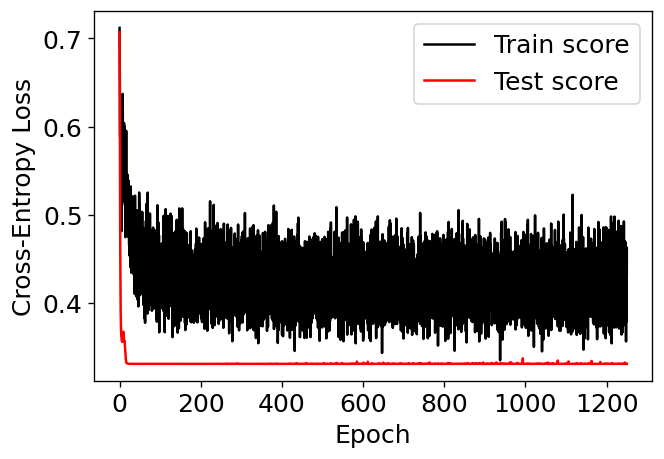

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:01<00:00, 20.31it/s]


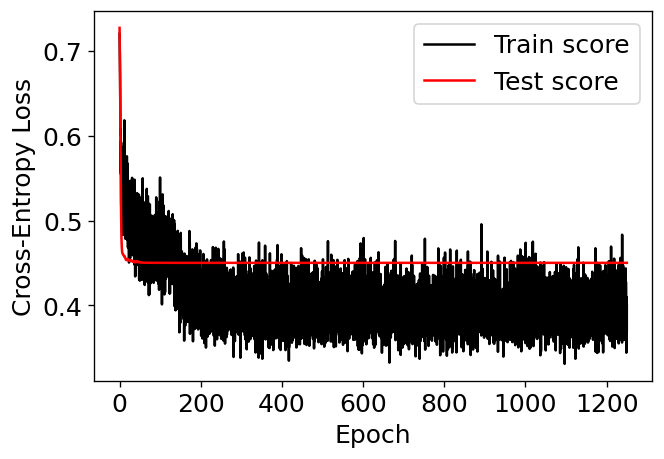

0.863013698630137 -1
0.863013698630137 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:00<00:00, 20.70it/s]


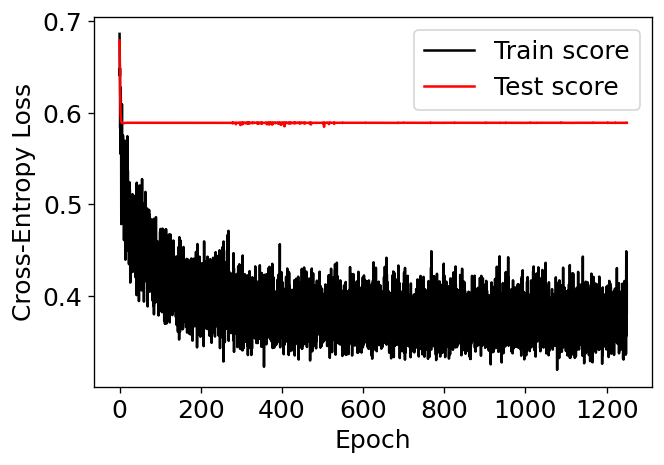

0.7241379310344828 -1
0.7241379310344828 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:01<00:00, 20.27it/s]


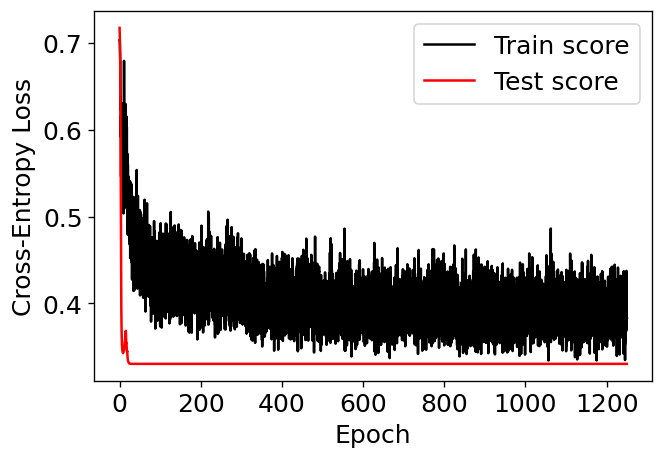

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:01<00:00, 20.39it/s]


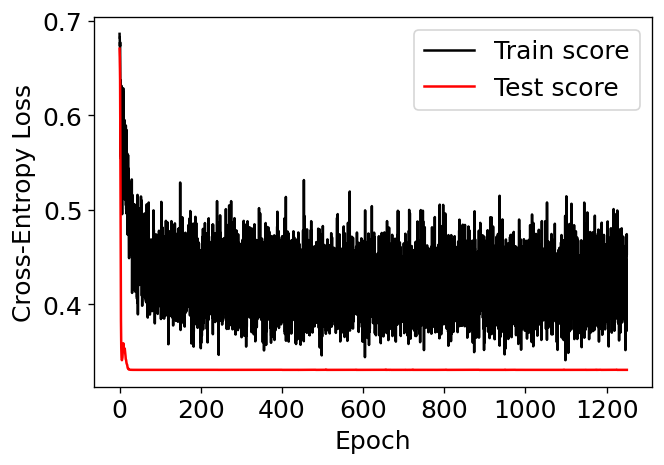

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:01<00:00, 20.25it/s]


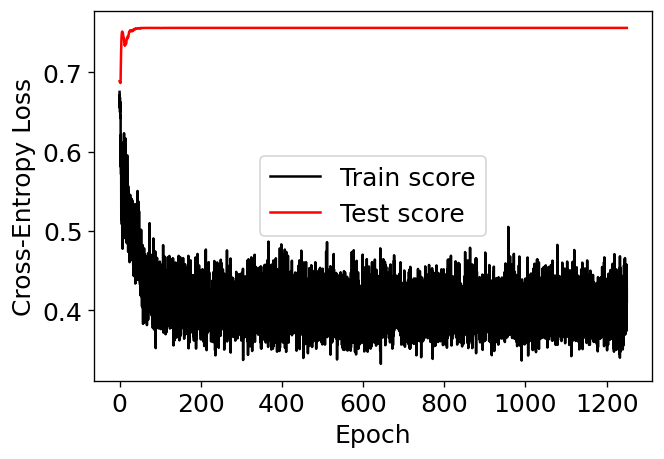

0.5573770491803278 -1
0.5573770491803278 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:01<00:00, 20.35it/s]


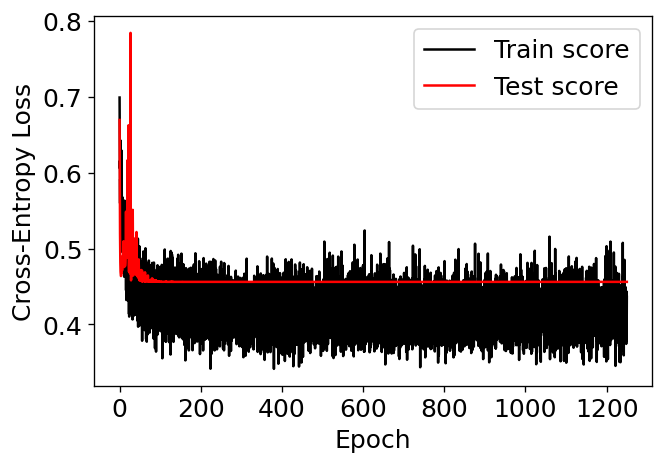

0.8571428571428571 -1
0.8571428571428571 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:03<00:00, 19.63it/s]


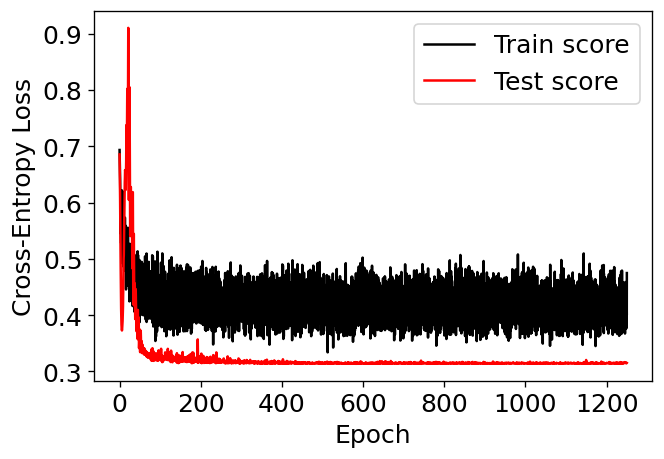

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1250/1250 [01:02<00:00, 20.00it/s]


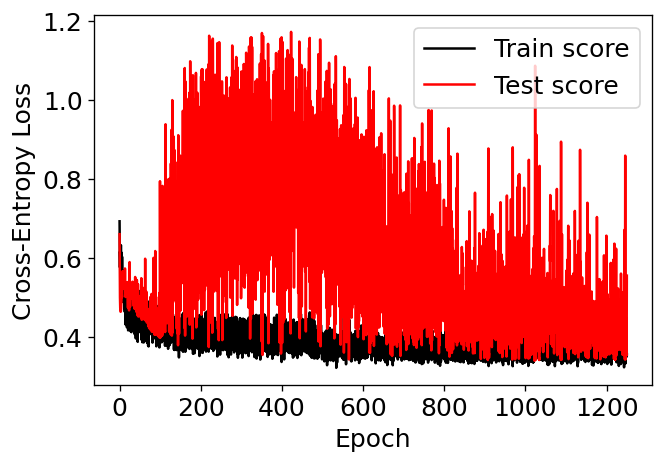

0.8181818181818182 -1
0.8181818181818182 0.7894736842105263
---------------------------------------------


100%|██████████| 1250/1250 [01:01<00:00, 20.27it/s]


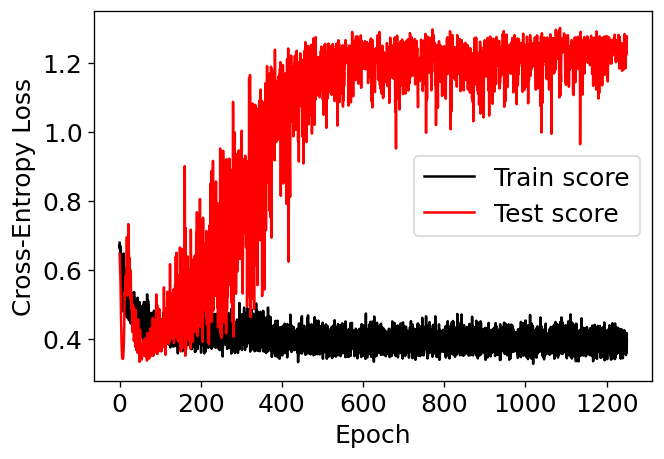

0.0 -1
0.0 -1.0
---------------------------------------------


100%|██████████| 1250/1250 [01:03<00:00, 19.74it/s]


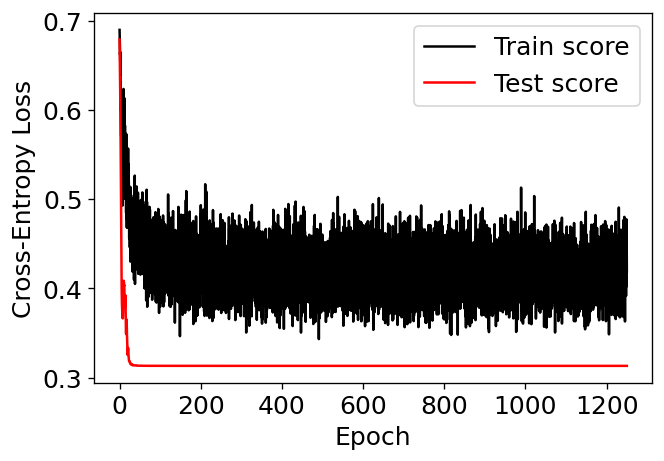

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1250/1250 [01:03<00:00, 19.69it/s]


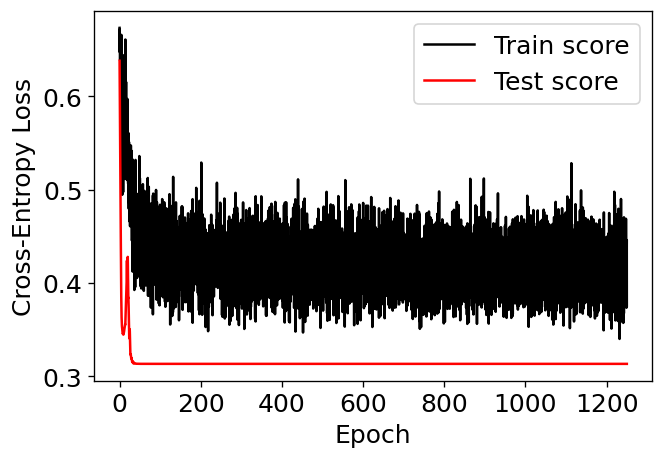

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1250/1250 [01:04<00:00, 19.33it/s]


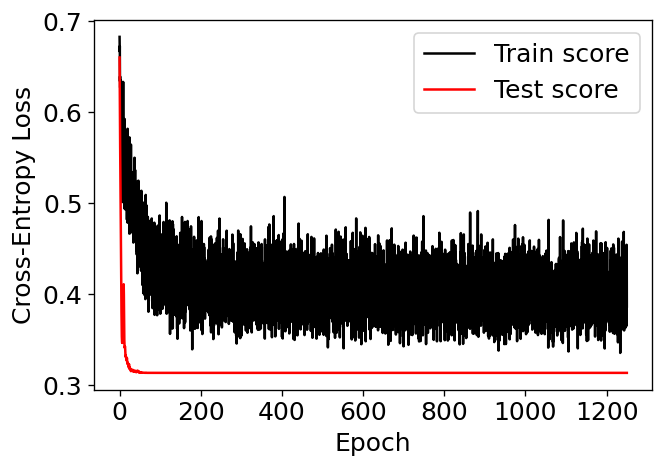

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1250/1250 [01:03<00:00, 19.68it/s]


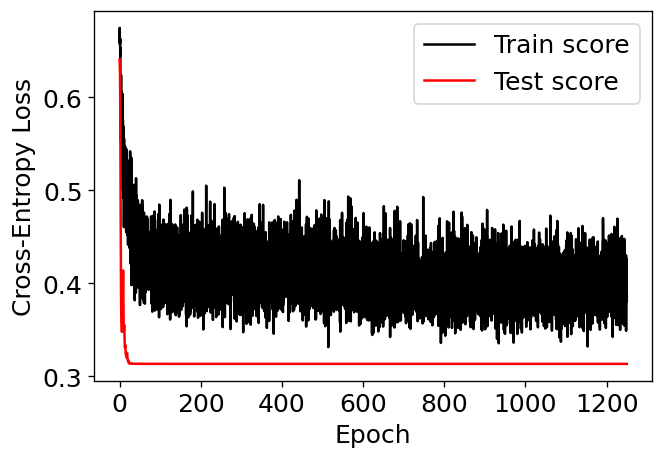

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1250/1250 [01:03<00:00, 19.78it/s]


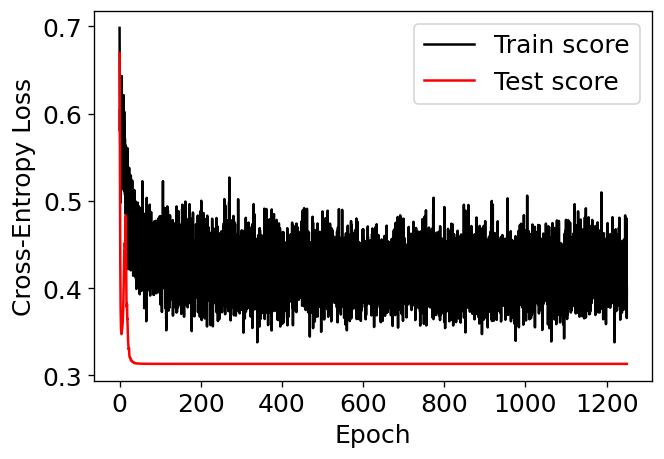

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1250/1250 [01:04<00:00, 19.49it/s]


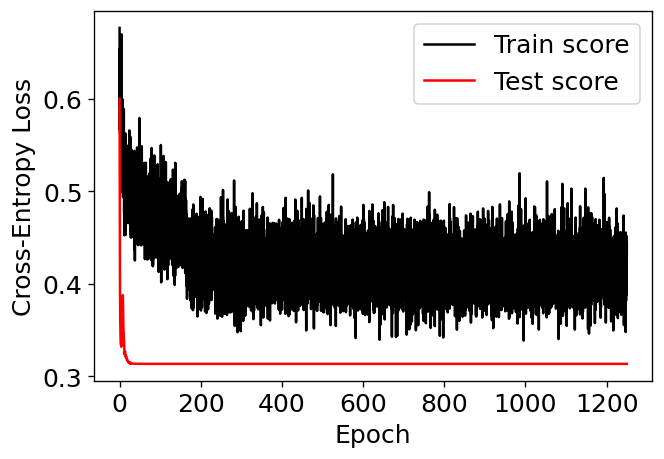

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1250/1250 [01:03<00:00, 19.56it/s]


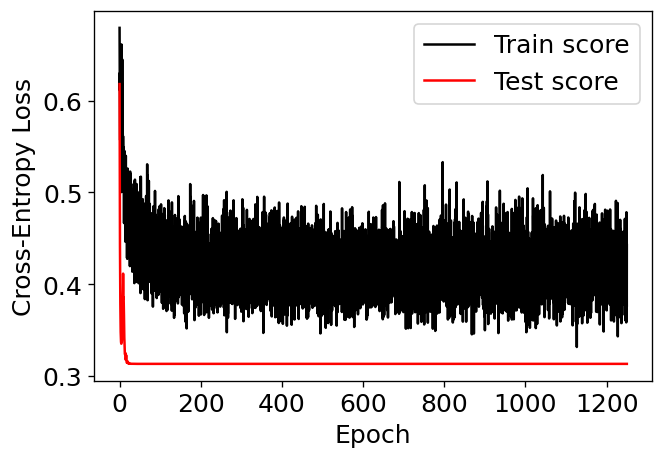

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1250/1250 [01:02<00:00, 20.09it/s]


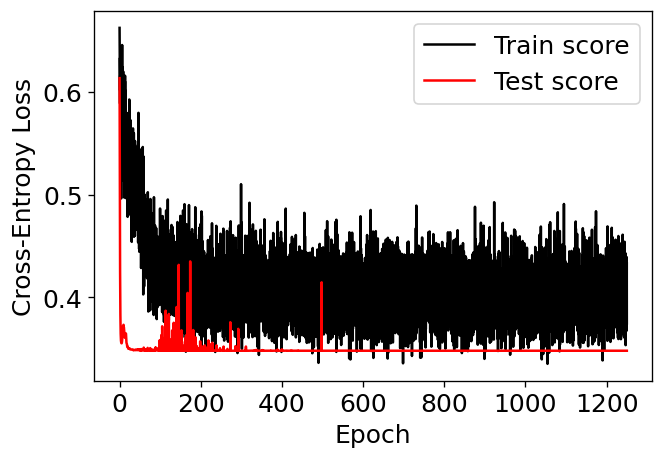

0.9655172413793104 -1
0.9655172413793104 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:02<00:00, 20.14it/s]


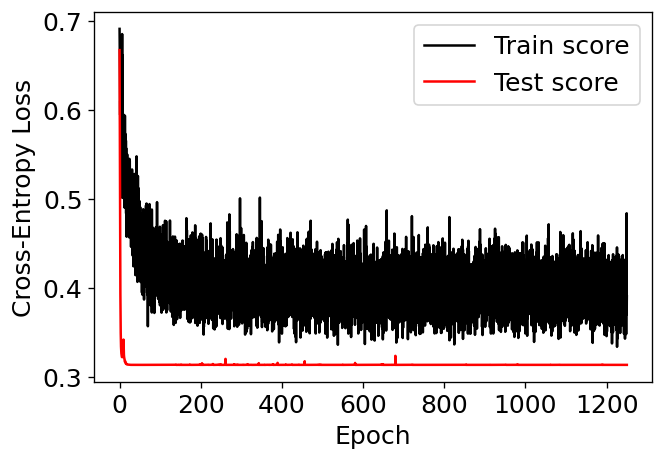

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1250/1250 [01:02<00:00, 19.89it/s]


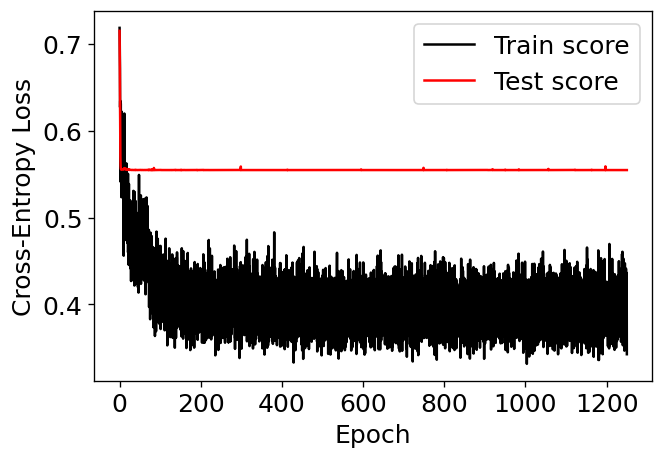

0.7586206896551724 -1
0.7586206896551724 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:01<00:00, 20.25it/s]


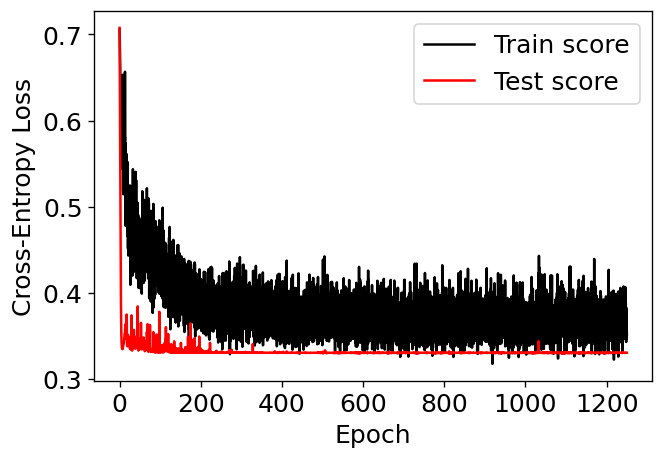

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:03<00:00, 19.61it/s]


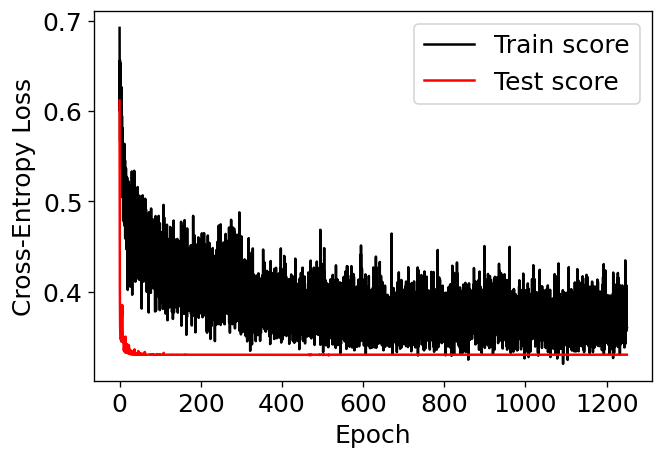

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:04<00:00, 19.26it/s]


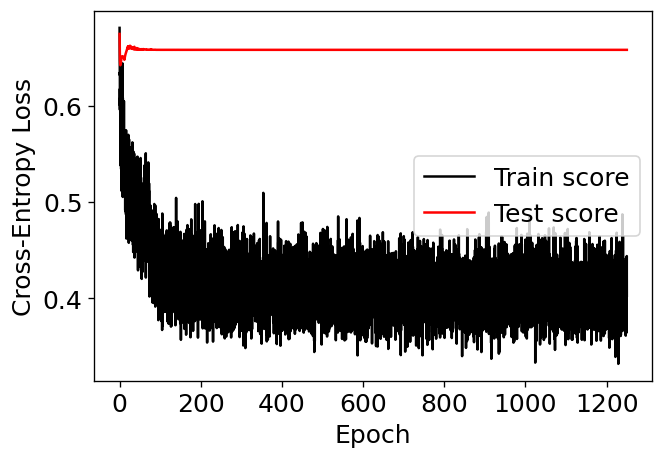

0.6551724137931034 -1
0.6551724137931034 0.0
---------------------------------------------


100%|██████████| 1250/1250 [01:03<00:00, 19.72it/s]


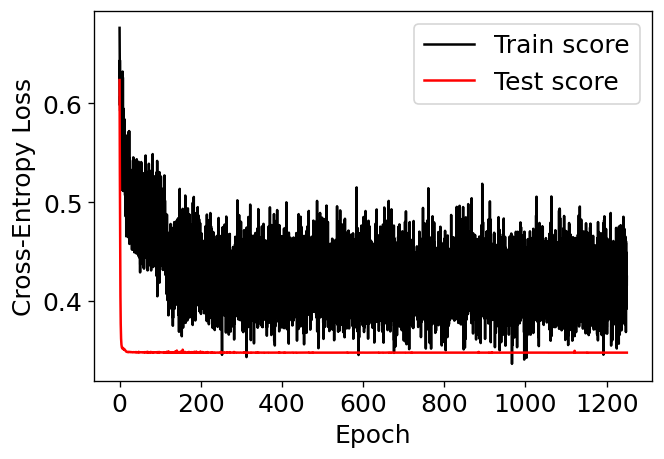

0.9655172413793104 -1
0.9655172413793104 0.0
---------------------------------------------
ARCH = VDFCNN_6060_CNN1_CONN1
TP = 5.705882352941177+/-13.111578654368381
TN = 31.941176470588236+/-22.782786557438474
FP = 2.7058823529411766+/-8.846831974563504
FN = 6.588235294117647+/-12.473778726165643
Acc = 0.8504997669678837+/-0.22658844632351755
TSS = -0.33027670027461253+/-0.5574586351971008
[1.         1.         0.56521739 0.86956522 0.76086957 0.95833333
 0.97826087 0.3        0.85897436 0.5472973  0.98275862 0.8630137
 0.72413793 0.98275862 0.98275862 0.55737705 0.85714286 1.
 0.81818182 0.         1.         1.         1.         1.
 1.         1.         1.         0.96551724 1.         0.75862069
 0.98275862 0.98275862 0.65517241 0.96551724]
[-1.         -1.          0.          0.          0.02926829 -1.
  0.          0.25        0.76428571 -0.0624355   0.          0.
  0.          0.          0.          0.          0.         -1.
  0.78947368 -1.         -1.         -1.        

In [ ]:
# NETWORK: VDFCNN_6060_CNN1_CONN1
ARCH = 'VDFCNN_6060_CNN1_CONN1'

tp = np.zeros([34], dtype=int)
tn = np.zeros([34], dtype=int)
fp = np.zeros([34], dtype=int)
fn = np.zeros([34], dtype=int)
acc = np.zeros([34], dtype=float)
tss = np.zeros([34], dtype=float)

for n_e, simfile in enumerate(simfiles):

  train_index = np.where(simnames != simfile)[0]
  test_index = np.where(simnames == simfile)[0]

  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 1000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = -1

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn_spec(f_test, labels_optim)

    print(_acc, optim_index)
    #if (_acc < 0.88):
      #print("RERUNNING THE SAMPLE...")
      #continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn_spec(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

print(acc)

print(tss)